HRT_6_ym_26_Three_Population_area_optimisation_side_all
AA matrix defined 12.058093786239624
BB and CC matrix defined
Time step is 0.8781799385446646 and steps 204


/content/solver.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  print('The normalised differences in between the time steps is ', np.max(np.abs(uxs - ux)) / np.max(uxs),
/content/solver.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  np.max(np.abs(uys - uy)) / np.max(uxs), t, time.time() - start_time_solver)
/content/solver.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  resid[pos] = np.mean(np.absolute(uxs - ux)) / np.mean(uxs)


The normalised differences in between the time steps is  inf inf 420.6648620708102 24.02502965927124
[-7.40520908e-05  1.20226205e-04  4.37400196e-04 -4.57884084e-04
  2.19999513e-04  2.95160236e-04 -4.56444272e-04  4.75118495e-04
 -5.15864373e-05 -5.07670899e-05]
[-1.02993306e-04 -2.23641295e-06 -7.94338922e-06 -2.68847334e-06
 -2.72078065e-08 -1.62831187e-07 -1.19579811e-06  5.07192621e-05
 -2.51066140e-06 -2.96055710e-05]
The normalised differences in between the time steps is  0.2596759797832128 0.1331020014939385 882.048078106671 48.33956170082092
[-8.55139394e-06 -4.76626277e-05  3.73479074e-06 -4.62551181e-05
 -1.59553726e-05 -5.15146843e-06 -2.72383580e-05  1.56417041e-04
 -5.87624255e-07  2.19892664e-05]
[-1.03203987e-05  2.12700899e-06 -2.76872832e-06  3.57021641e-05
 -7.86512871e-08 -2.93474023e-06 -5.12915219e-07  4.43756244e-05
 -1.92909611e-07  1.24971498e-05]
The normalised differences in between the time steps is  0.09536444714347006 0.04137102578511063 1340.03105497205

Progress of simulation: 100%|█████████████████████▉| 100.80000000000011/101 [39:39<00:04, 24.90s/it]


 HRT: 6.0 hours
 Glucose removal percent: 2.3480554110909604 
 Acetate removal percent: -6.320189488781504 
 COD removal percent: 1.5667340170548278 
 Current Density: 0.10002634005744905 

86411.78243214774
(array([0.09882789, 0.10781712, 0.1059919 , ..., 0.10955866, 0.10940329,
       0.10623937]), array([9.94742467e-06, 1.09263213e-05, 1.04646600e-05, ...,
       1.08696876e-05, 1.05557979e-05, 1.04989431e-05]))
2.2407951256941887 86411.78243214774
Supply both Ux and Uy data to overlay streamlines
Supply both scatter positions and data to overlay scatter density


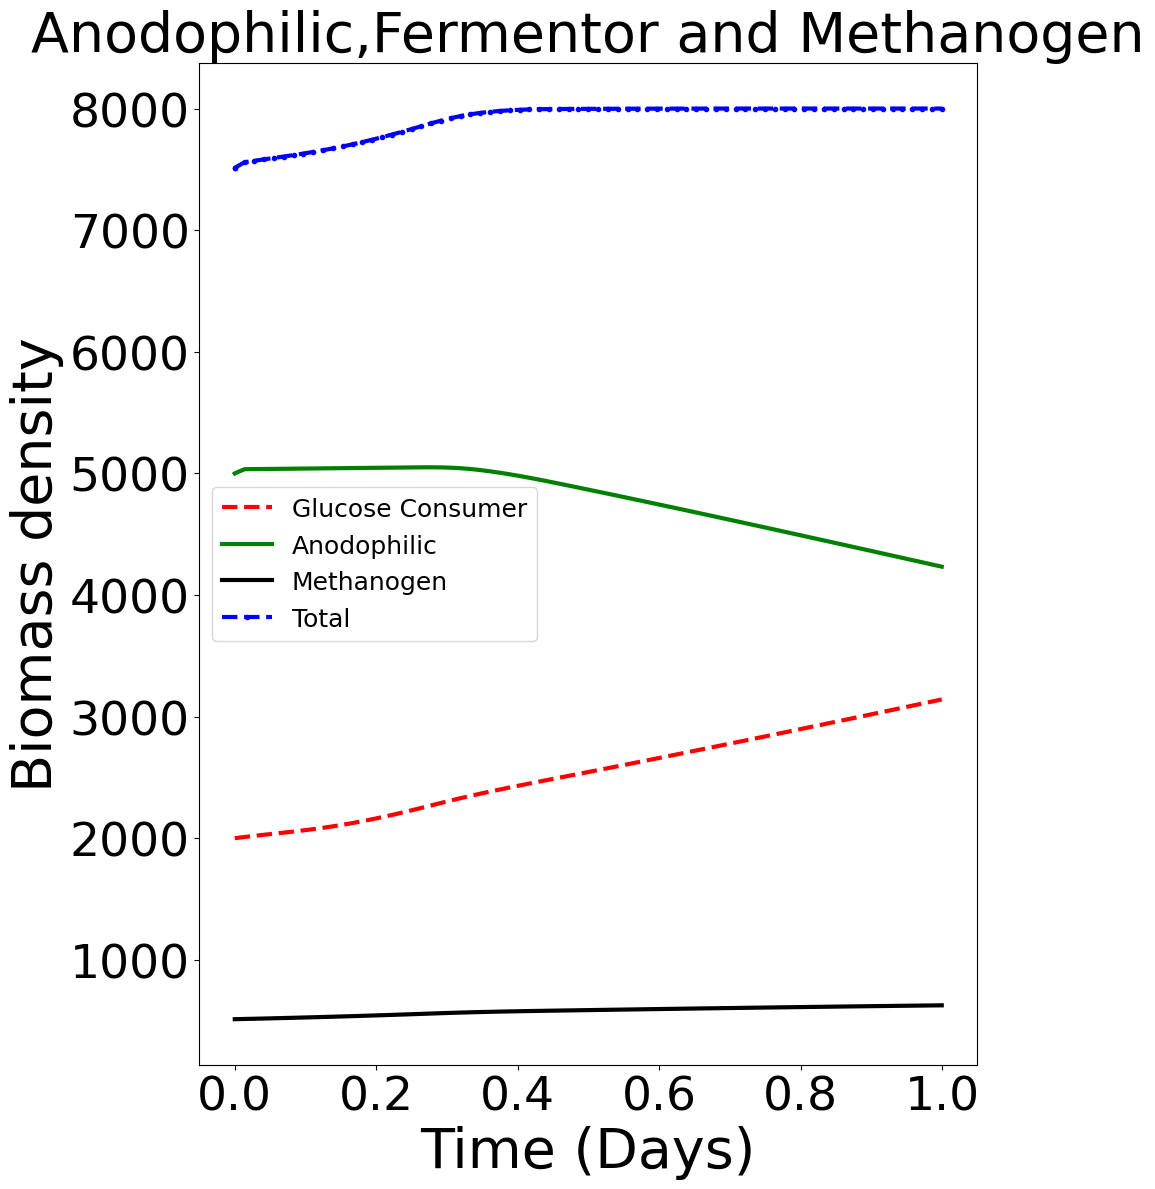

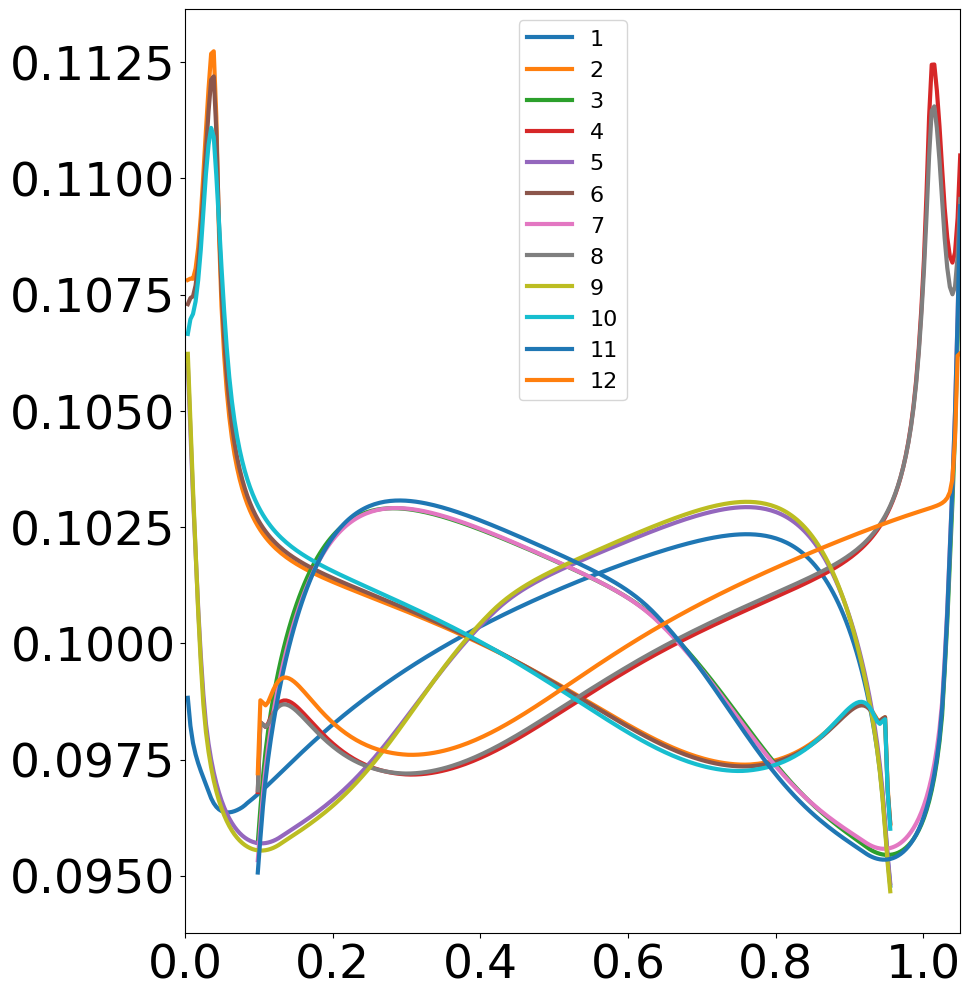

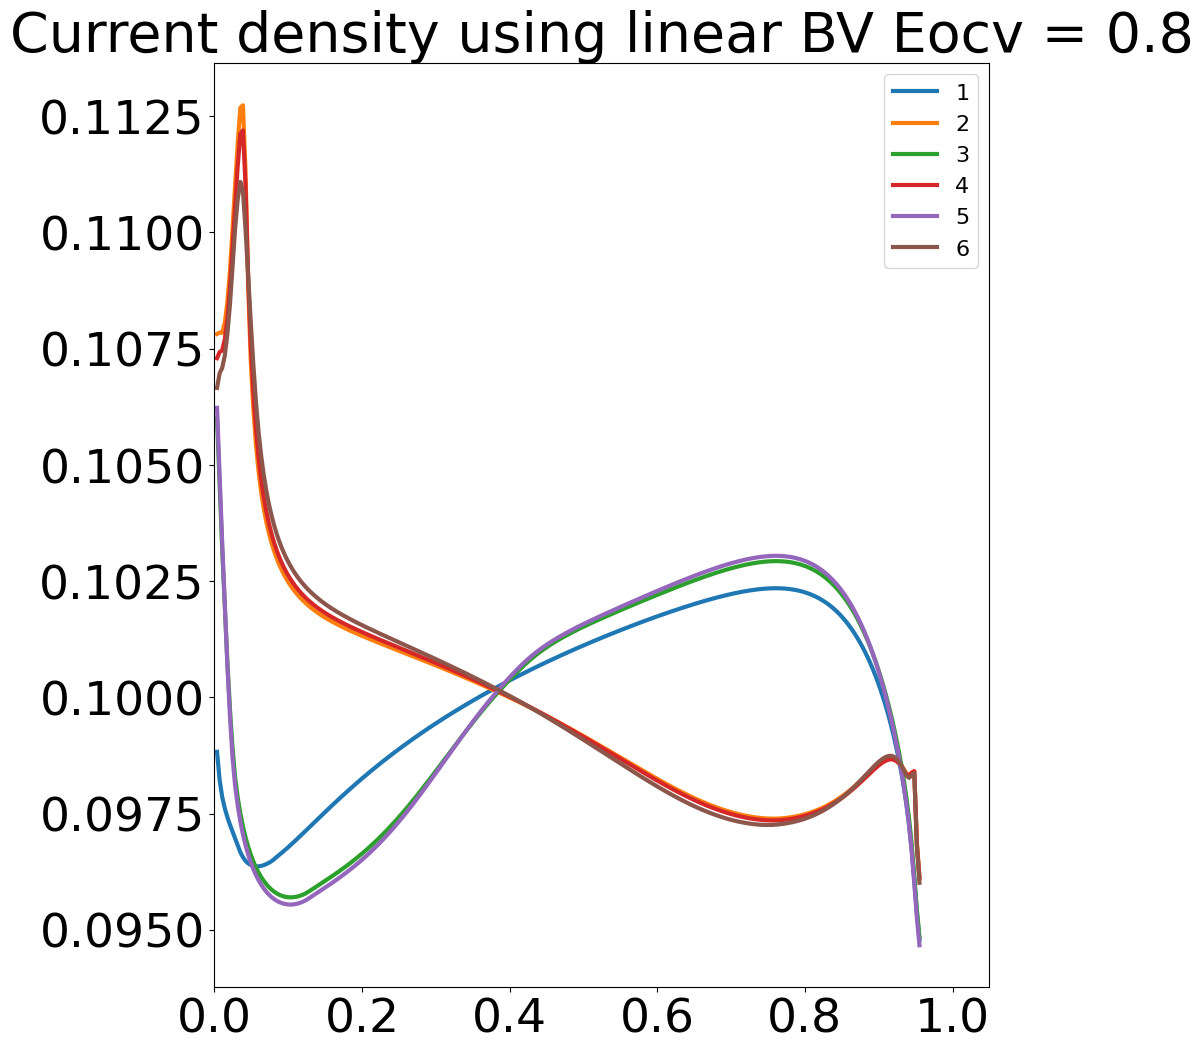

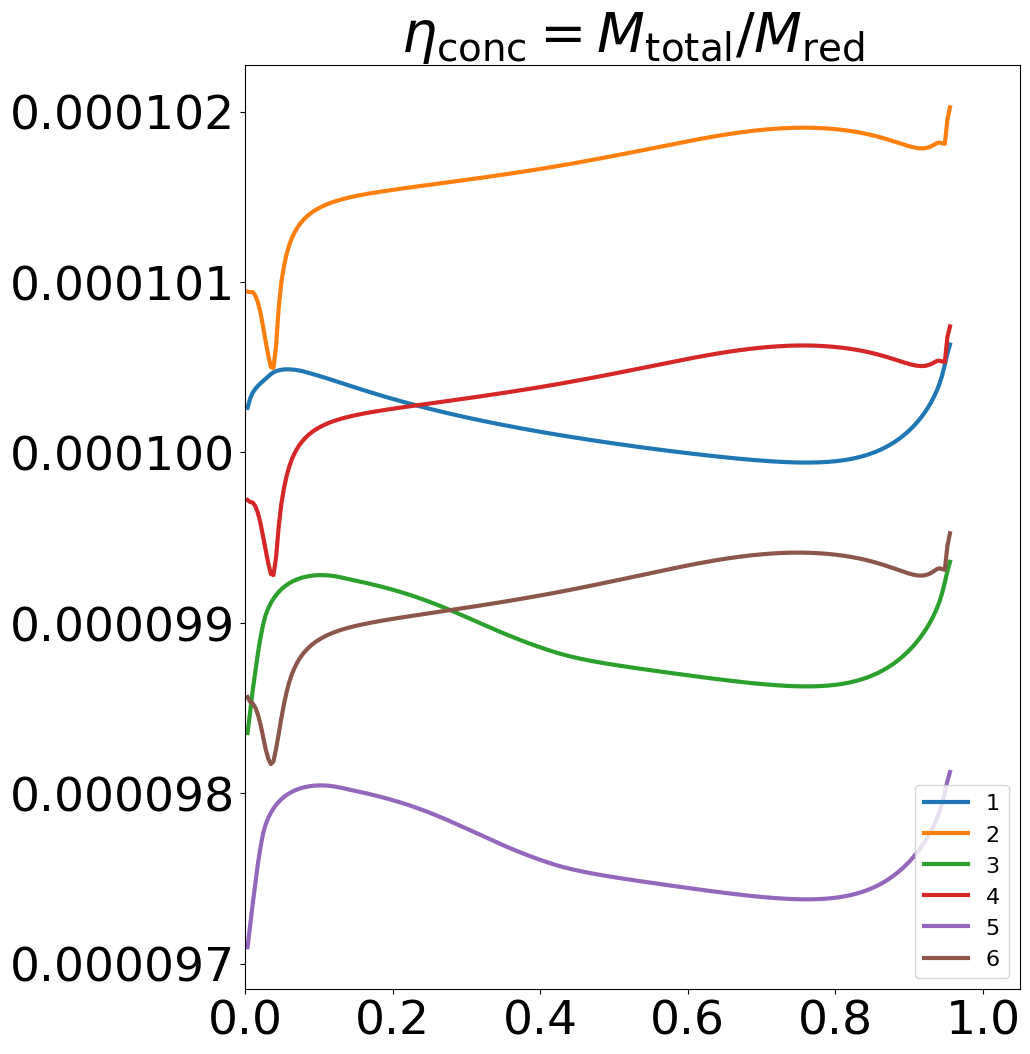

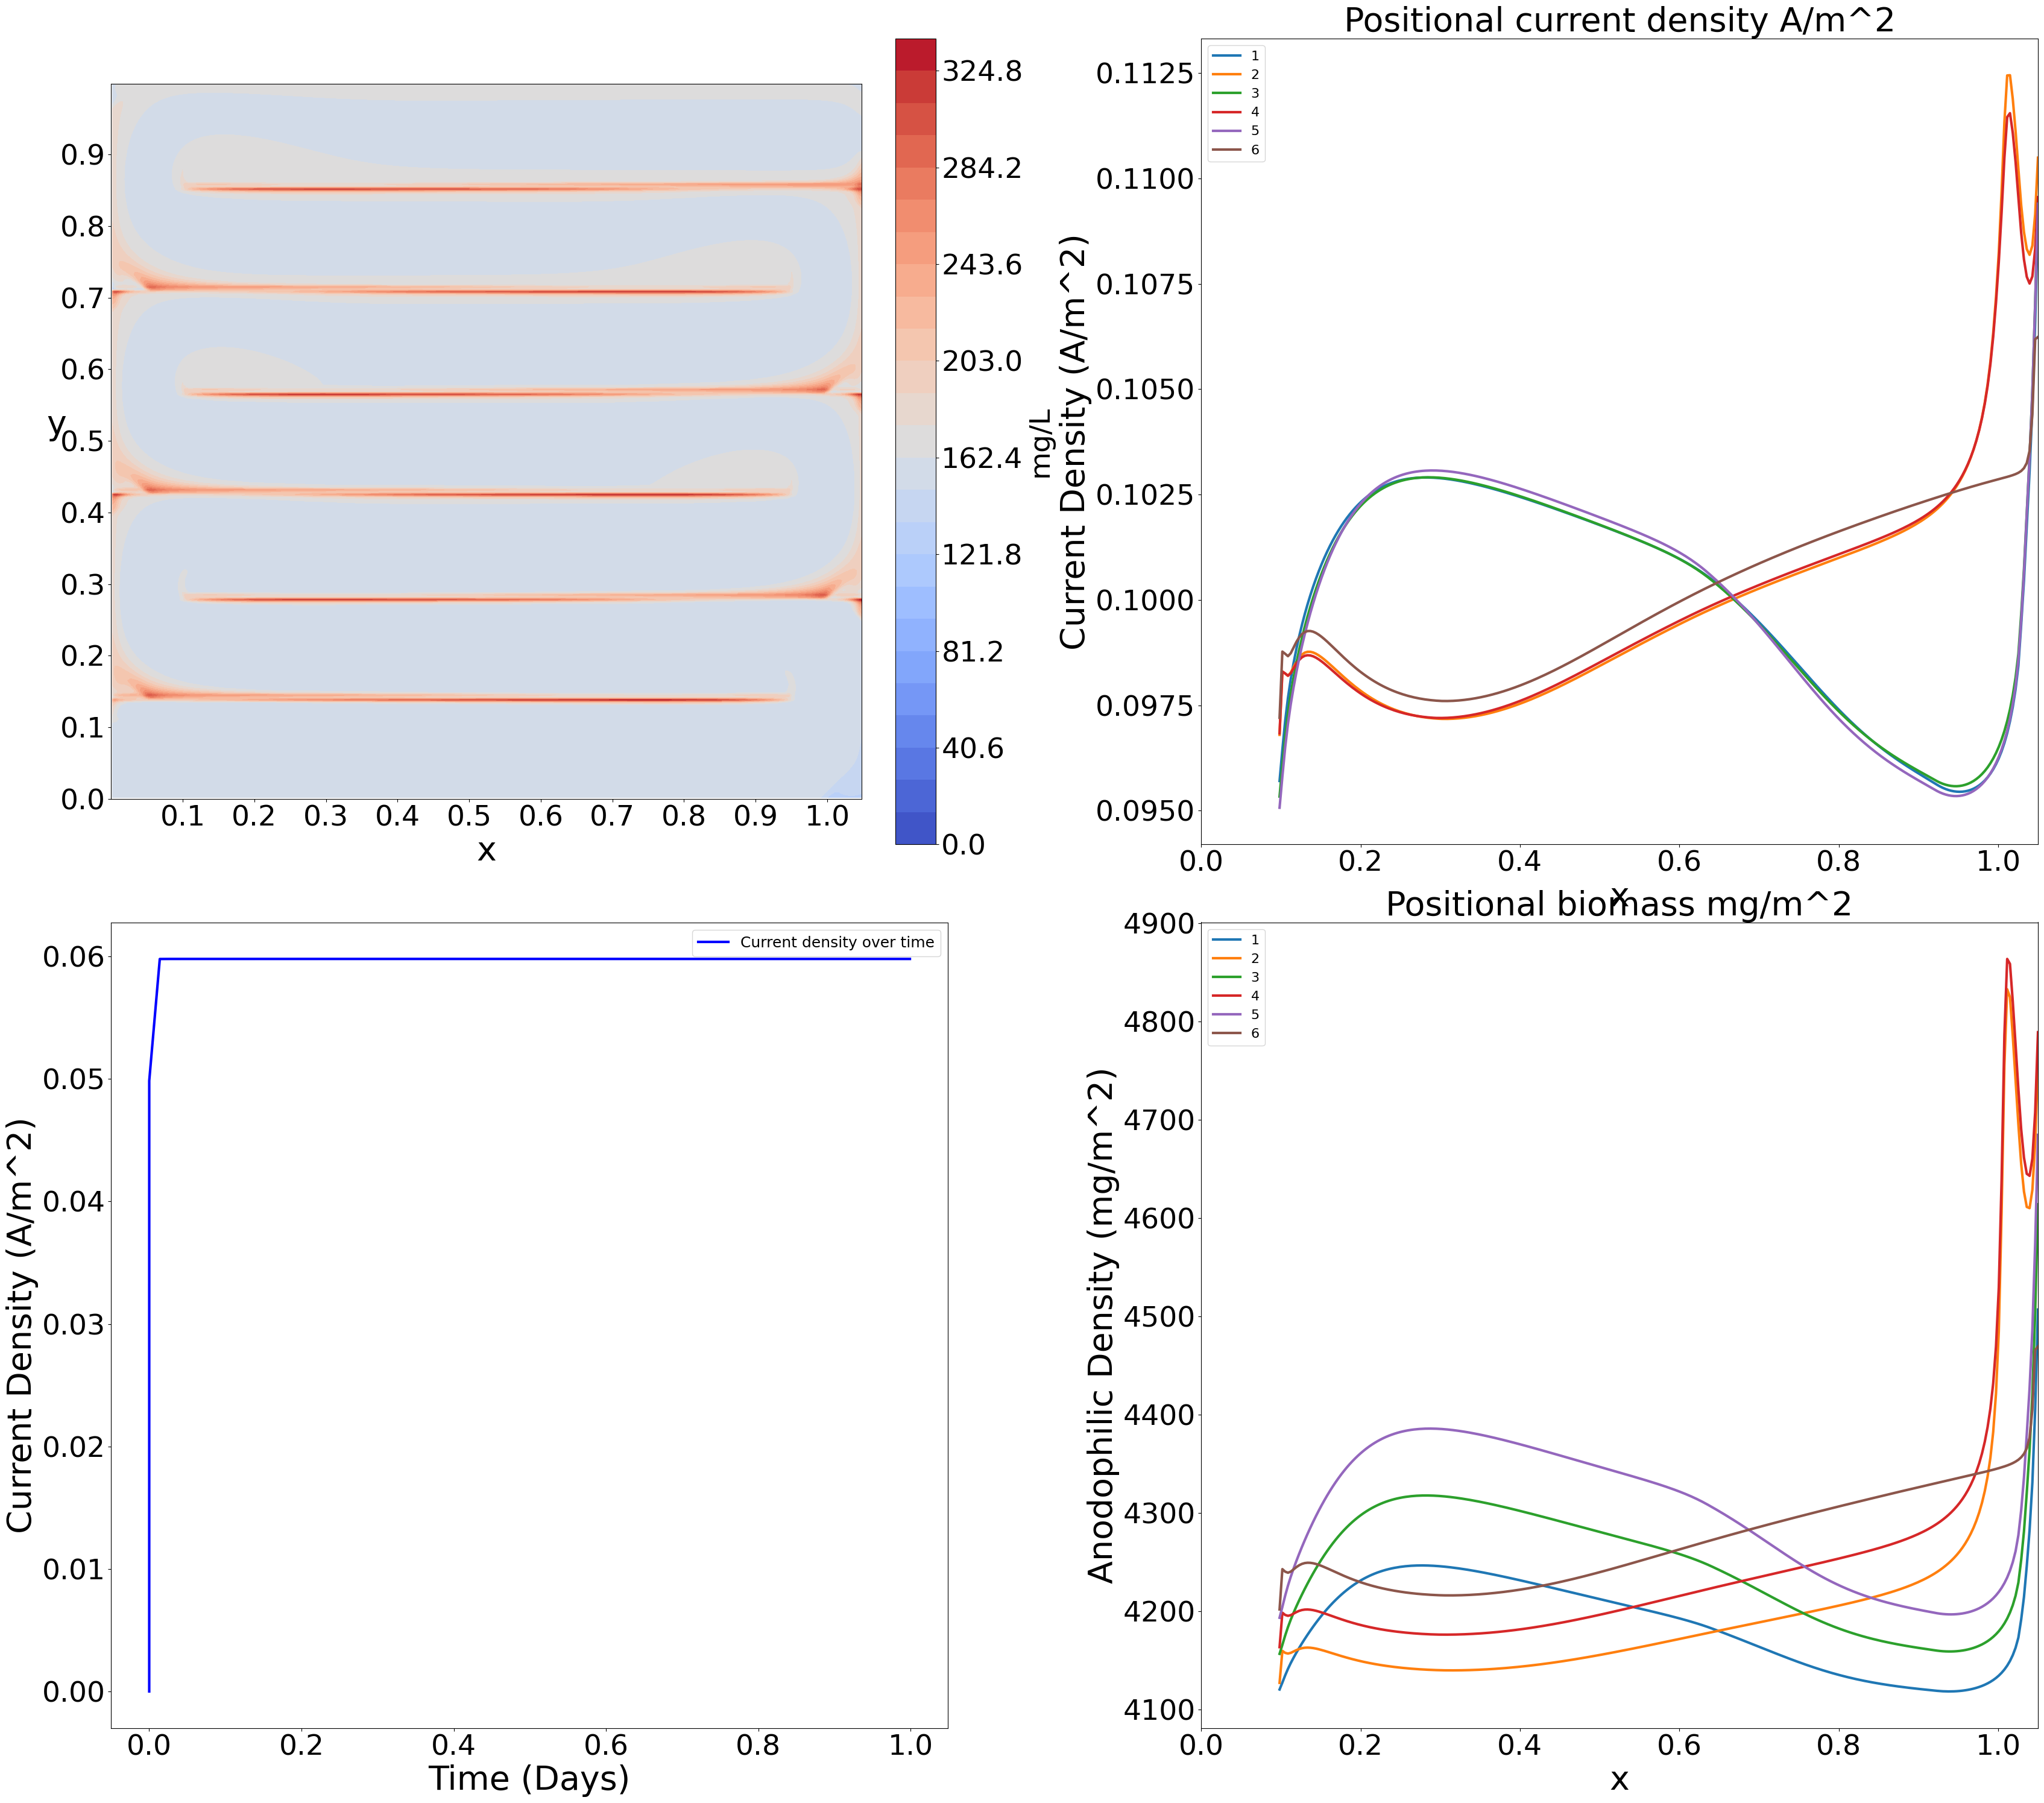

In [ ]:
# -*- coding: utf-8 -*-

# Copyright 2020 Jordan Day
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#


# import numpy as np
# import scipy as sp
from scipy import sparse
# from scipy.sparse import linalg
# import matplotlib.pyplot as plt
# import time
from tqdm import tqdm
from Fluid_classes import *
from Plotting_functions import *
import os
from pathlib import Path
import solver

np.random.seed(0)
nx = 300
ny = 300
nz = 1
Lx = 1.05  # length in m
Ly = 1  # length in m
Lz = 1.05  # length in m
hrt = 6  # hrt set in any given time units TC is the conversion to seconds
file_name = 'HRT_{}_ym_26_Three_Population_area_optimisation_side_'.format(int(hrt))  # File name to save output data

hrt *= TC_hour  # The hydraulic retention time converted into seconds
baffle_length = 91 / 100  # This is the fraction of the tank a baffle takes up in x
baffle_pairs = 3  # Number of baffle pairs (RHS+LHS) = 1 pair.

# Baffle param
rho = 8000
# Runtime for reactor system
RT = 1
RT *= TC_day
dt_max = 8
k = 20  # Store data every k min, 1 is every min, 2 every 2 min
D = 1 / hrt
anode_side = 'all'  # can either be 'all', 'influent', 'effluent' 'front_loaded' based on the layout you wish to test
file_name += anode_side
print(file_name)

dx = Lx / nx
dy = Ly / ny
x = np.linspace(0, Lx, nx).T
y = np.linspace(0, Ly, ny).T
[yy, xx] = np.meshgrid(np.linspace(dy / 2, Ly - dy / 2, ny), np.linspace(dx / 2, Lx - dx / 2, nx))

system = domain(Lx, Ly, Lz, nx=nx, ny=ny)

flux = (Lx * Ly) / hrt  # The "area flux" through the system
nxy = nx * ny
nxy_one = (nx + 1) * (ny + 1)
psi = np.zeros((nx + 1, ny + 1))  # This is the stream function
boundary = np.zeros((nx + 1, ny + 1))  # We set this to 1 on all boundary points
boundary[0, :] = 1
boundary[-1, :] = 1
boundary[:, 0] = 1
boundary[:, -1] = 1

edges = boundary
psi[0, 0:ny + 3] = flux
psi[:, -1] = flux
psi, boundary, in_out_points, in_start, out_start = system.influent_effluent_regions(baffle_pairs, baffle_length,
                                                                                     dy * 18, psi, boundary, flux)

bdata = psi[boundary == 1]

file_a = 'hrt' + str(hrt).replace('.', '_') + '_nx' + str(nx) + '_ny' + str(ny) + '_Lx' + str(Lx) + '_Ly' + str(
    Ly) + '_pairs' + str(baffle_pairs) + '_width' + str(np.round(baffle_length, decimals=1)).replace('.',
                                                                                                     '_') + '.csv'
file_x = 'Ux_' + file_a
file_y = 'Uy_' + file_a
data_folder = Path(os.getcwd(),'Velocity Fields')

try:
    ux = np.genfromtxt(data_folder / file_x, delimiter=',')
    uy = np.genfromtxt(data_folder / file_y, delimiter=',')
    print('Velocity Files loaded from text files')
except:
    psi, ux, uy, resid = solver.steady_state(boundary, psi, nx, ny, dx, dy,error=1e-6)  # Using function to determine steady state
    save_velocity_fields(file_a,['Velocity Fields'],ux,uy)
    print('Velocity fields have been determined and saved in text files \n')

# %%
external = np.zeros(boundary.shape)
external[0, :] = 1
external[-1, :] = 1
external[:, 0] = 1
external[:, -1] = 1
internal = boundary - external
bio_loc = np.zeros(boundary.shape)
bio_loc[:, 0:ny] += internal[:, 1:ny + 1]
bio_loc[:, 1:ny + 1] += internal[:, 0:ny]
bio_loc = bio_loc[0:nx, 0:ny]
if baffle_length == 0 and baffle_pairs == 0:
    bio_loc[1:-1, -2] = 1
    bio_loc[1:-1, 1] = 1

positional = np.nonzero(np.mean(bio_loc, 0))
switch = np.zeros(bio_loc.shape)
if anode_side == 'influent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][0:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('influent facing anodes are active')
elif anode_side == 'effluent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][1:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('effluent facing anodes are active')
elif anode_side == 'front_loaded':
    switch[:, positional[0][10:20:1]] = 1
    glucose_loc = 1 * bio_loc
    bio_loc *= switch
    #glucose_loc = glucose_loc - bio_loc
    print('First 5 carts are fermenting only')
else:
    anode_side = 'all'
    #switch[:, positional[0][11:20:1]] = 1
    #bio_loc *= switch
    glucose_loc = 1 * bio_loc
    print('All anodes are active')

bio_number = np.count_nonzero(bio_loc)
glucose_number = np.count_nonzero(glucose_loc)
# %%

anode_numbers = np.count_nonzero(np.mean(bio_loc, 0))

# Determine anode area based on biofilm and baffle length
Ai = dx * Lz
A = baffle_length * nx * Ai
# A = Lx * Lz #anode area
# Ai = A/nx # area per cell

Vol = Lx * Ly * Lz * 1e3  # Volume in
Voli = dx * dy * Lz * 1e3  # Local volume in L

convert_m2_l = Ai / Voli
convert_l_m2 = Voli / Ai

z1 = MicrobialPopulation(5000 * np.ones(bio_number)  # np.random.normal(loc = 1000,scale = 10,size = (nx,2)) #initial
                         , 7.9 / TC_day  #7.9 / TC_day  # consumption
                         , 2*0.7 / TC_day  # growth
                         , 0.02  # decay
                         , 20 # sub monod const
                         , 'Anodophilic'  # Defining anodophilic species as class
                         , 5000
                         , mediator_monod=0.2 * 1)

z3 = MicrobialPopulation(512 * np.ones(glucose_number)
                         , 8.3 / TC_day
                         , 2*0.3 / TC_day
                         , 0.02
                         , 80
                         , 'Methanogenic',
                         5000)

z2 = MicrobialPopulation( 2000 * np.ones(glucose_number)
                         , 4.8/ TC_day
                         , 2*0.4 / TC_day
                         , 0.02
                         , 100
                         , 'Glucose Consumer'
                         , 2000)

# Doubles initial bacteria conc on biofilms without electrogens
z2_space = 0*glucose_loc
z2_space[glucose_loc == 1] = z2.current
z2_space[glucose_loc - bio_loc == 1] = 4000
z2.current = z2_space[glucose_loc==1]

z3_space = 0*glucose_loc
z3_space[glucose_loc == 1] = z3.current
z3_space[glucose_loc - bio_loc == 1] = 2*z3.current.max()
z3.current = z3_space[glucose_loc==1]


s = Substrate(100 * np.ones((nx, ny)), influent=150, diffusion=1e-9, name='Acetate')
s.current = s.update_influent(baffle_pairs, in_out_points, ny)
s2 = Substrate(100* np.ones((nx, ny)),influent= 1500,diffusion= 1e-9,name = 'Glucose') # 300 or 1500
s2.current = s2.update_influent(baffle_pairs, in_out_points, ny)
s2.s_yield = 0.7 ################################################### Latest run using 0.8 as Ac yield

m_total = 1  # mg-M / mg-Z Initial mediator

mox = Parameters(0.99 * m_total * np.ones(bio_number), name='Oxidised Mediator')

mred = Parameters(m_total - mox.initial, name='Reduced Mediator')
Ym = 26#22.75  # mg-M /mg -s 36#32
m = 2  # mol-e / mol-M
gamma = 663400  # mg-M/mol-M
T = 298  # K
j0 = 1#e-2  # 1e-2-> almost identical to 1, but much faster run times
BV_full = False

j_min = 1.60
j_max = 1.60  # 1.34#0.64
##############################################
# changed here and j_0 ###
E_min_scaled = j_min * (A * 500)  # /(R*T/(m*F*j0))Anode area times sum of res
E_max_scaled = j_max * (A * 500)  # /(R*T/(m*F*j0)) Anode area times sum of res

#############################################
j_test = 1.5  # .4#2.4#1.6#2.4/10  # 40 j0 = 1e-4
# Full BV stable for hrt = 2, 6, j0 = 1e-4 , J_test = 1.4

Rin = Parameters(0, minimum=7, maximum=7, k=0.006 * A / Vol, name='Internal Resistance')
Rex = 1  # ohm
E_test = 0.8  # j_test * (A * (Rin.minimum+Rex)) # j_test*(R*T/(m*F*j0)+500*A*(0.92/0.08)/(0.92/0.08))

E = Parameters(0, minimum=E_test, maximum=E_test, k=0.0006, name='Voltage')
# E = Parameters(0, minimum=10, maximum=10, k=0.0006, name='Voltage')

# E_ocv = E_test * bio_loc
# E_ocv[:,270:273:2] = 0.9*(A * (Rin.minimum+Rex))
# E_ocv = E_ocv[bio_loc == 1]
# E.current = E_ocv


pref = gamma / (m * F)
I = Parameters(0, name='Current (Not to be confused with current value)')
s_blank = np.zeros((bio_number, 5000))
ij = 0
t = GeneralVariable(0, name='Time')
Rin.current = Rin.minimum  # +(Rin.maximum - Rin.minimum)*np.exp(-Rin.k*sum(z1.initial)/nx) + Rex
Rin.storage[0] = Rin.current

# setting up locations for biofilm
# bio_loc = np.zeros((nx,ny))
bio_upper = np.zeros((nx, ny))
bio_lower = np.zeros((nx, ny))
bio_lower[:, -2] = 1  # used for plotting
bio_upper[:, 1] = 1
consump = np.zeros((nx, ny))  # setting consumption array
med_dist = np.zeros(consump.shape)

ux_max = np.max(ux)  # max velocity based on steady state
uy_max = np.max(uy)  # max vel from steady state
# Creating sparse matrix for biofiolm diffusion]
positions = [-1, 0, 1]
diag_x = np.array([[1 / (dx ** 2)], [-2 / (dx ** 2)], [1 / (dx ** 2)]]).repeat(nx, axis=1)
diag_y = np.array([[1 / (dy ** 2)], [-2 / (dy ** 2)], [1 / (dy ** 2)]]).repeat(ny, axis=1)
Dx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # d/dx mat Alternate approach to using diffuse_S array
Dy = sp.sparse.spdiags(diag_y, positions, ny, ny)  # d/dy mat
kappa_bio = 1e-12  # diffusion rate for biofilm
Dx_bio = sp.sparse.spdiags(diag_x, positions, nx, nx).tolil()
Dx_bio[0, -1] += 1 / (dx ** 2)  # Periodic Boundary Conditions
Dx_bio[-1, 0] += 1 / (dx ** 2)  # Periodic BC
# Dx_bio[0,-1] += 1/(dx**2) # non peridoic bc
# Dx_bio[0,-1] += 1/(dx**2) # Need to fix
Dx_bio *= kappa_bio  # setting up diffusion array for biofilm
Dx_bio = Dx_bio.tocsr()

Bx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # tolil()
By = sp.sparse.spdiags(diag_y, positions, ny, ny)
Iy = sp.sparse.eye(ny)
Ix = sp.sparse.eye(nx)
Diffuse_s = (sp.sparse.kron(Iy, Bx) + sp.sparse.kron(By, Ix)).tolil()

bio_diffusion_x = sp.sparse.kron(Iy, Bx).tolil()
temp_location = np.zeros((nx + 1, ny + 1))
temp_location[:-1, :-1] = bio_loc

for ii in np.arange(nxy):
    ix = int(ii % nx)
    iy = int(np.floor(ii / nx))
    jj = iy * (nx + 1) + ix
    if boundary[ix, iy] * boundary[ix, iy + 1] == 1:  # Boundary on left
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dx ** 2)  #
        if ix != 0:
            Diffuse_s[ii, ii - 1] = 0
    if boundary[ix + 1, iy] * boundary[ix + 1, iy + 1] == 1:  # Boundary on right
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dx ** 2)
        if ix != nx - 1:
            Diffuse_s[ii, ii + 1] = 0

    if boundary[ix, iy] * boundary[ix + 1, iy] == 1:  # Boundary below
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != 0:
            Diffuse_s[ii, ii - nx] = 0

    if boundary[ix, iy + 1] * boundary[ix + 1, iy + 1] == 1:  # Boundary above
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != ny - 1:
            Diffuse_s[ii, ii + nx] = 0
    if temp_location[ix, iy] * temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix != 0:
        if temp_location[ix - 1, iy] * temp_location[ix, iy] == 0:
            bio_diffusion_x[ii, ii] += 1 / (dx ** 2)

    if temp_location[ix, iy] + temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] -= 1 / (dx ** 2)

Diffuse_s = Diffuse_s.tocsr()
LU = sp.sparse.linalg

bio_diffusion_x = 0*1e-9 * bio_diffusion_x.tocsr()
z1.biomass_diffusion(bio_loc,bio_diffusion_x)
z2.biomass_diffusion(glucose_loc,bio_diffusion_x)
z3.biomass_diffusion(glucose_loc,bio_diffusion_x)



z1.calculate_positional_distribution(bio_loc)
temp = bio_diffusion_x.dot(np.reshape(z1.positional_distribution.T, nxy))
temp = np.reshape(temp.T, (ny, nx)).T
temp[bio_loc != 1] = 0  # Deals with mass produced outside of biofilm! (temp fix)

del temp_location

s.storage[:, :, 0] = s.initial
s.current[:, :] = s.initial  # This line causes s.initial to be linked to s.now

dt = min(dt_max, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
        2 * s.diffusion * (dx ** 2 + dy ** 2)))
# dt = np.floor(dt*100)/100

ii = 0
rk = np.array([[0, 1 / 2, 1 / 2, 1], [0, 1, 1, 1], [1, 2, 2, 1]]).T
bound_out = np.zeros(s.current.shape)
bound_in = np.zeros(s.current.shape)
bound_out[-1, :] = 1
bound_out[:, -1] = 1
bound_out[:, 0] = 1
bound_in[-2, :] = 1
bound_in[:, -2] = 1
bound_in[:, 1] = 1

E.current = E.minimum
Rin.current = Rin.minimum
Rsig = Rin.current + Rex

mred.current = m_total - mox.current
eta_conc = R * T / (m * F) * np.log(m_total / mred.current)

med_dist[bio_loc == 1] = Ai * mred.current / mox.current
summation = np.array([Rsig * np.sum(med_dist, 0), ] * nx)
summation_shaped = summation[bio_loc == 1]
j = (mred.current / mox.current * (E.current - eta_conc)) / (
        R * T / (m * F * j0) + summation_shaped)
del eta_conc

print("System will simulate a {} baffle system with a fluid HRT of {} hours and bio runtime of {} days".format(
    2 * baffle_pairs, hrt / TC_hour, RT / TC_day))

start_time_bio = time.time()
storage_steps = int(k * 60 / dt)
z1.diffused *= 0
z2.diffused *= 0
z2.diffused *= 0
combined_max = 8000
total_time = time.time()
pbar = tqdm(total=101, desc="Progress of simulation", ncols=100, )

fermenting_bio_loc = glucose_loc - bio_loc

while t.current < RT + 10:
    ii += 1
    lt = time.time()
    irk = 0
    consump *= 0  # Reset consumption
    while irk < 4:  # replaced with while loop to allow for adaptive timesteps
        if irk == 0:
            z1.intermediate = z1.current
            z3.intermediate = z3.current
            s.intermediate = s.current
            mox.intermediate = mox.current
            mred.intermediate = m_total - mox.intermediate

            z2.intermediate = z2.current
            s2.intermediate = s2.current
        else:
            z1.update_intermediate(rk, irk, dt)
            z3.update_intermediate(rk, irk, dt)
            s.update_intermediate(rk, irk, dt)
            mox.update_intermediate(rk, irk, dt)
            mred.intermediate = m_total - mox.intermediate

            s.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s.influent

            z2.update_intermediate(rk, irk, dt)
            s2.update_intermediate(rk, irk, dt)
            s2.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s2.influent



        if (mox.current + (dt / 6) * mox.ddt2 > m_total).any() or (
                mox.current + rk[irk, 0] * dt * mox.ddt1 > m_total).any():
            # If over estimating rk4 loop is reset with smaller timestep
            irk = 0
            dt *= 0.5
            continue


        local_g = np.reshape(s2.intermediate[glucose_loc == 1], (glucose_number))
        z2.update_growth_and_consumption(local_g)
        z2.first_timestep()
        z2.second_timestep(rk, irk)

        local_s = np.reshape(s.intermediate[bio_loc == 1], bio_number)
        local_s_meth = np.reshape(s.intermediate[glucose_loc == 1], (glucose_number))

        substrate_mean_surface = anode_surface_sum(Ai * local_s, bio_loc) / A

        j, eta_act = current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
        I_anode = anode_surface_sum_repeated(j * Ai, bio_loc)
        mediator_current_density_term = I_anode / A

        # local_s = np.reshape(s.intermediate[bio_loc == 1], (bio_number))
        z1.update_growth_and_consumption(local_s, mox.intermediate)
        z3.update_growth_and_consumption(local_s_meth)
        # diff_z1 = 0  # *Dx_bio.dot(vdata1[0,])
        # diff_z3 = 0  # *Dx_bio.dot(vdata1[1,]) # diffusion of X and Z
        z1.biomass_diffusion(bio_loc, bio_diffusion_x)
        z3.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z2.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z1.first_timestep()
        z1.second_timestep(rk, irk)
        z3.first_timestep()
        z3.second_timestep(rk, irk)
        mox.ddt1 = -Ym * z1.consumption + pref * j / z1.intermediate
        mox.second_timestep(rk, irk)
        s.calculate_advection(ux, uy, dx, dy)  # Advection is slowest process
        s.calculate_diffusion(Diffuse_s)  # diff is second slowest
        s.calculate_consumption(z1, z3, biofilm_location=bio_loc, convert_m2_l=convert_m2_l,biofilm_location2=glucose_loc)  # rapid
        fluid_time = time.time()
        s.first_timestep()  # Timestepping is almost as slow as diff
        s.created = -s2.s_yield * s2.consumption
        s.ddt1 += s.created
        s.second_timestep(rk, irk)
        s2.calculate_advection(ux, uy, dx, dy)
        s2.calculate_diffusion(Diffuse_s)
        s2.calculate_consumption(z2, biofilm_location=glucose_loc, convert_m2_l=convert_m2_l)
        s2.first_timestep()
        s2.second_timestep(rk, irk)
        irk += 1  # move forward in rk4 loop
        if irk == 4 and (mox.current + (dt / 6) * mox.ddt2 > m_total).any():
            irk = 0
            dt *= 0.5
            # print('Loop restart')
            continue

    z2.update_current(dt)
    s2.update_current(dt)

    z1.update_current(dt)
    z3.update_current(dt)
    s.update_current(dt)
    mox.update_current(dt)
    mred.current = m_total - mox.current

    j, eta_act, eta_conc = current_density(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
    I.current = np.sum(Ai * j)
    t.current += dt
    dt = min(dt_max, dt * 2, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
            2 * s.diffusion * (dx ** 2 + dy ** 2)))  # increase timestep up to 2 or double previous timestep
    s.current = s.update_influent(baffle_pairs, in_out_points, ny)
    z2.calculate_positional_distribution(glucose_loc)
    z3.calculate_positional_distribution(glucose_loc)
    temp_shared1 = z2.positional_distribution[bio_loc == 1]
    temp_shared2 = z3.positional_distribution[bio_loc == 1]
    total_biomass = z1.current + temp_shared1 + temp_shared2#+ z2.current
    if (total_biomass > rho).any():
        z1.current[total_biomass > rho] *= rho/total_biomass[total_biomass > rho]
        temp_shared1[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        temp_shared2[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        z2.positional_distribution[bio_loc == 1] = temp_shared1
        z3.positional_distribution[bio_loc == 1] = temp_shared2


    temp_mass1 = z2.positional_distribution[fermenting_bio_loc == 1]
    temp_mass2 = z3.positional_distribution[fermenting_bio_loc == 1]
    total_biomass2 = temp_mass1 + temp_mass2
    if (total_biomass2 > rho).any():
        temp_mass1[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        temp_mass2[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        z2.positional_distribution[fermenting_bio_loc == 1] = temp_mass1
        z3.positional_distribution[fermenting_bio_loc == 1] = temp_mass2

    z2.current = z2.positional_distribution[glucose_loc == 1]
    z3.current = z3.positional_distribution[glucose_loc == 1]

    if ii % storage_steps == 0 or ii == 1:  # round(t.now,2)%(k*60) == 0 : #Storage of data
        ij += 1
        z1.storage[:, ij] = z1.current
        z3.storage[:, ij] = z3.current
        mox.storage[:, ij] = mox.current
        mred.storage[:, ij] = mred.current
        I.storage[ij] = I.current
        t.storage[ij] = t.current
        s.storage[:, :, ij] = s.current
        s_blank[:, ij] = z1.storage[:,ij-1] - z1.storage[:,ij]  # (muz-Kda)*vdata[0,]
        z2.storage[:,ij] = z2.current
        s2.storage[:,:,ij] = s2.current

        increase = round((t.current - t.storage[ij - 1]) / (RT + 20) * 100, 1)
        pbar.update(round(increase, 1))

#

gl_removal_percent = (s2.influent - mean_effluent(s2,in_out_points,out_start))/s2.influent*100
s_removal_percent = (s.influent - mean_effluent(s,in_out_points,out_start))/s.influent*100
influent_cod = s2.influent*1.07+s.influent*1.06
effluent_cod = mean_effluent(s2,in_out_points,out_start)*1.07 + mean_effluent(s,in_out_points,out_start)*1.06
cod_removal_percent = (influent_cod - effluent_cod)/influent_cod*100
print('\n HRT: {} hours\n Glucose removal percent: {} \n Acetate removal percent: {} \n COD removal percent: {} \n Current Density: {} \n'.format(hrt/TC_hour,
    gl_removal_percent,s_removal_percent,cod_removal_percent,j.mean()))

#save_data_classes_two_substrates(file_name,['Output','temp'],s,z1,mox,mred,j,t,s2,z2)
save_data_classes_two_substrates(file_name,['Output','Three_Population_Files'],s,z1,mox,mred,j,t,s2,z2,z3)

z1.update_mean(0)
z2.update_mean(0)
z3.update_mean(0)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average),sty = 'r--',linelabel = 'Glucose Consumer',new_fig=True)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z1.average),sty = 'g-',linelabel = 'Anodophilic',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z3.average),sty = 'k-',linelabel = 'Methanogen',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average+z1.average+z3.average),sty = 'b.--',linelabel = 'Total',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )

print(t.current)
plot_positional_data(x, j, bio_loc, new_fig=True)

print(current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=False))
current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=True)

print(dt, t.current)
plot_positional_data(x, j, bio_loc, new_fig=True, side='Left',
                     title='Current density using linear BV Eocv = {}'.format(E.current))

plot_positional_data(x, eta_conc, bio_loc, side='left', new_fig=True,
                     title='$\eta_\mathrm{conc} = M_\mathrm{total}/M_\mathrm{red}$')

plt.figure(figsize=(34, 30))
plt.subplot(221)
plot_contour(xx, yy, s.current)
plt.subplot(222)
plot_positional_data(x, j, bio_loc, side='right', title='Positional current density A/m^2',ylab = 'Current Density (A/m^2)',xlab = 'x')
plt.subplot(223)
plot_time_series(t.storage[0:ij + 1] / TC_day, I.storage[0:ij + 1] / (20 * A), linelabel='Current density over time',ylab = 'Current Density (A/m^2)',xlab = 'Time (Days)')
plt.subplot(224)
plot_positional_data(x, z1.current, bio_loc, side='right', title='Positional biomass mg/m^2',ylab = 'Anodophilic Density (mg/m^2)',xlab = 'x')


HRT_12_ym_26_Three_Population_area_optimisation_side_all
AA matrix defined 14.14826250076294
BB and CC matrix defined
Time step is 1.7563598770893292 and steps 102


/content/solver.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  print('The normalised differences in between the time steps is ', np.max(np.abs(uxs - ux)) / np.max(uxs),
/content/solver.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  np.max(np.abs(uys - uy)) / np.max(uxs), t, time.time() - start_time_solver)
/content/solver.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  resid[pos] = np.mean(np.absolute(uxs - ux)) / np.mean(uxs)


The normalised differences in between the time steps is  inf inf 289.51820774966563 18.247246265411377
[-3.81927429e-05 -4.49831854e-06  2.16021766e-04 -2.22111351e-04
  1.18025723e-04  1.55763517e-04 -2.18158553e-04  2.14105027e-04
 -2.21264748e-05 -3.66876860e-05]
[-4.44763828e-05  4.11774853e-06 -2.16825401e-06  2.14192426e-07
 -3.43721075e-09 -7.77299913e-10 -2.31663036e-07  3.08793696e-06
 -8.20881916e-07 -2.68980294e-05]
The normalised differences in between the time steps is  0.18423836682417566 0.10004248583677079 586.6644622086419 32.052457094192505
[ 2.93984163e-06  2.29826036e-05  5.93693911e-06 -1.24787393e-05
 -1.32171986e-05 -1.38537235e-05 -1.78255267e-05  4.53643192e-06
  1.36266209e-06  9.57224987e-06]
[ 1.00322425e-07 -2.26636923e-06 -7.91878722e-07 -5.87209996e-07
 -3.11196170e-09 -2.18741061e-08 -1.56962479e-07  8.06561931e-06
 -1.38955593e-08  8.49222537e-06]
The normalised differences in between the time steps is  0.08511428927892105 0.04434479213581803 883.810716

Progress of simulation: 100%|█████████████████████▉| 100.80000000000011/101 [19:11<00:02, 11.13s/it]


 HRT: 12.0 hours
 Glucose removal percent: 6.95776702676973 
 Acetate removal percent: -3.999781851581436 
 COD removal percent: 5.970096804741472 
 Current Density: 0.10002701176619759 

86411.51600643432
(array([0.09829422, 0.09813092, 0.10500518, ..., 0.06958102, 0.084935  ,
       0.10495816]), array([9.62473562e-06, 9.68743923e-06, 9.81500204e-06, ...,
       6.84099955e-06, 7.83118327e-06, 9.70718846e-06]))
4.591716669667108 86411.51600643432
Supply both Ux and Uy data to overlay streamlines
Supply both scatter positions and data to overlay scatter density


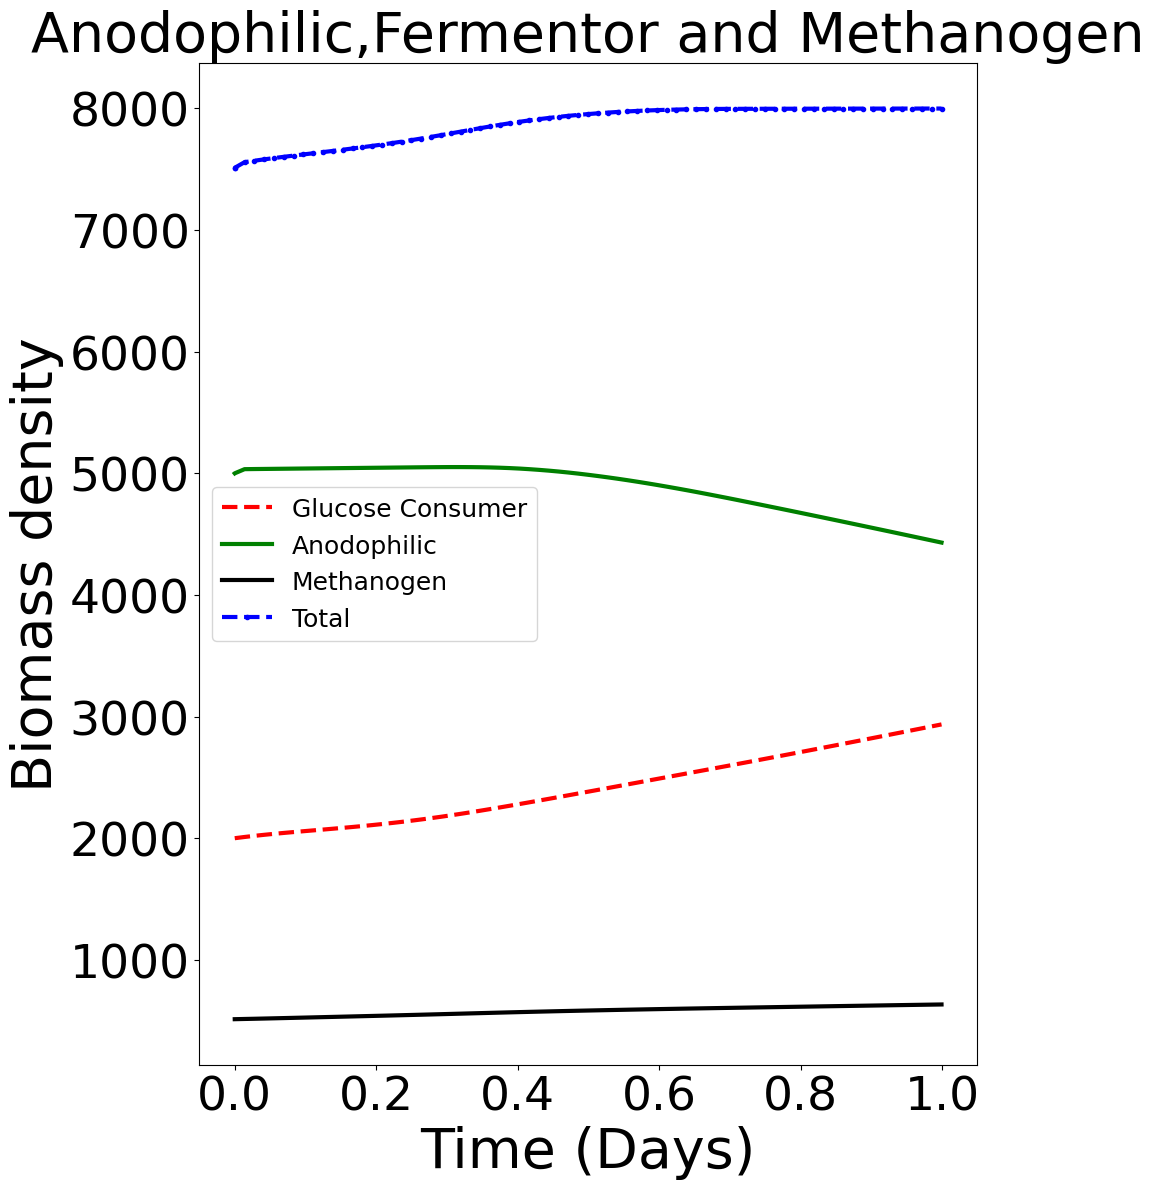

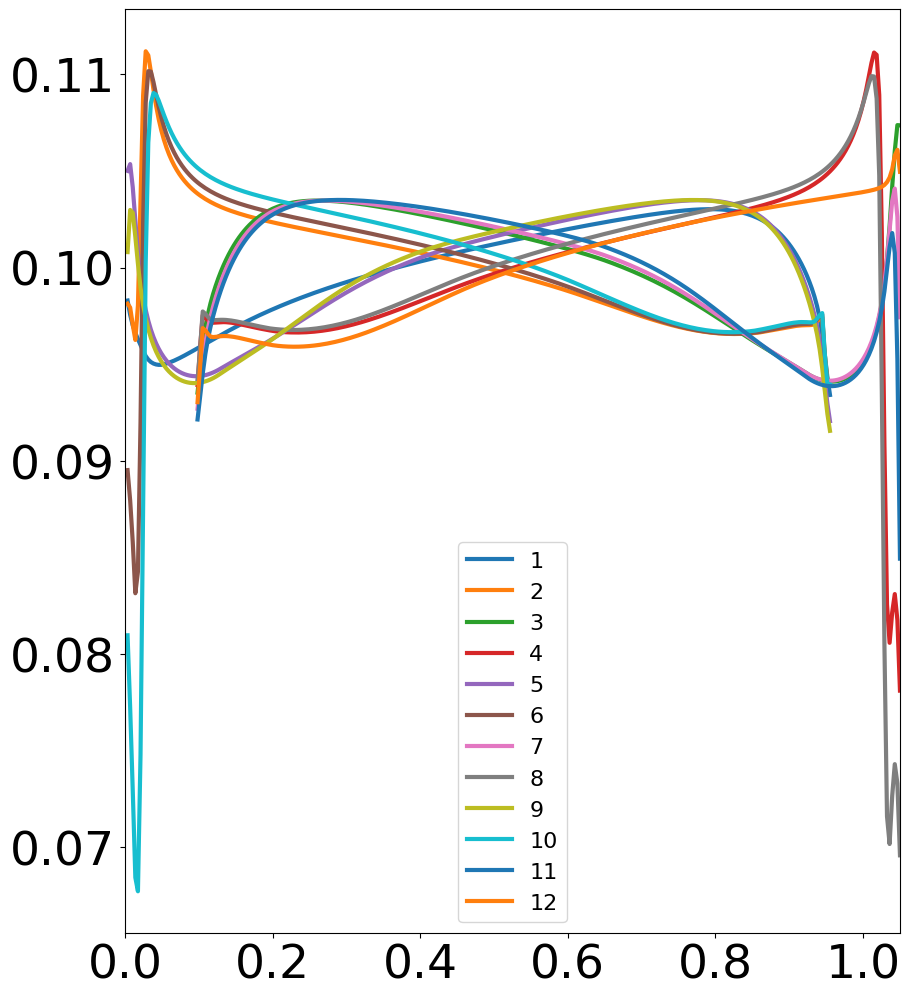

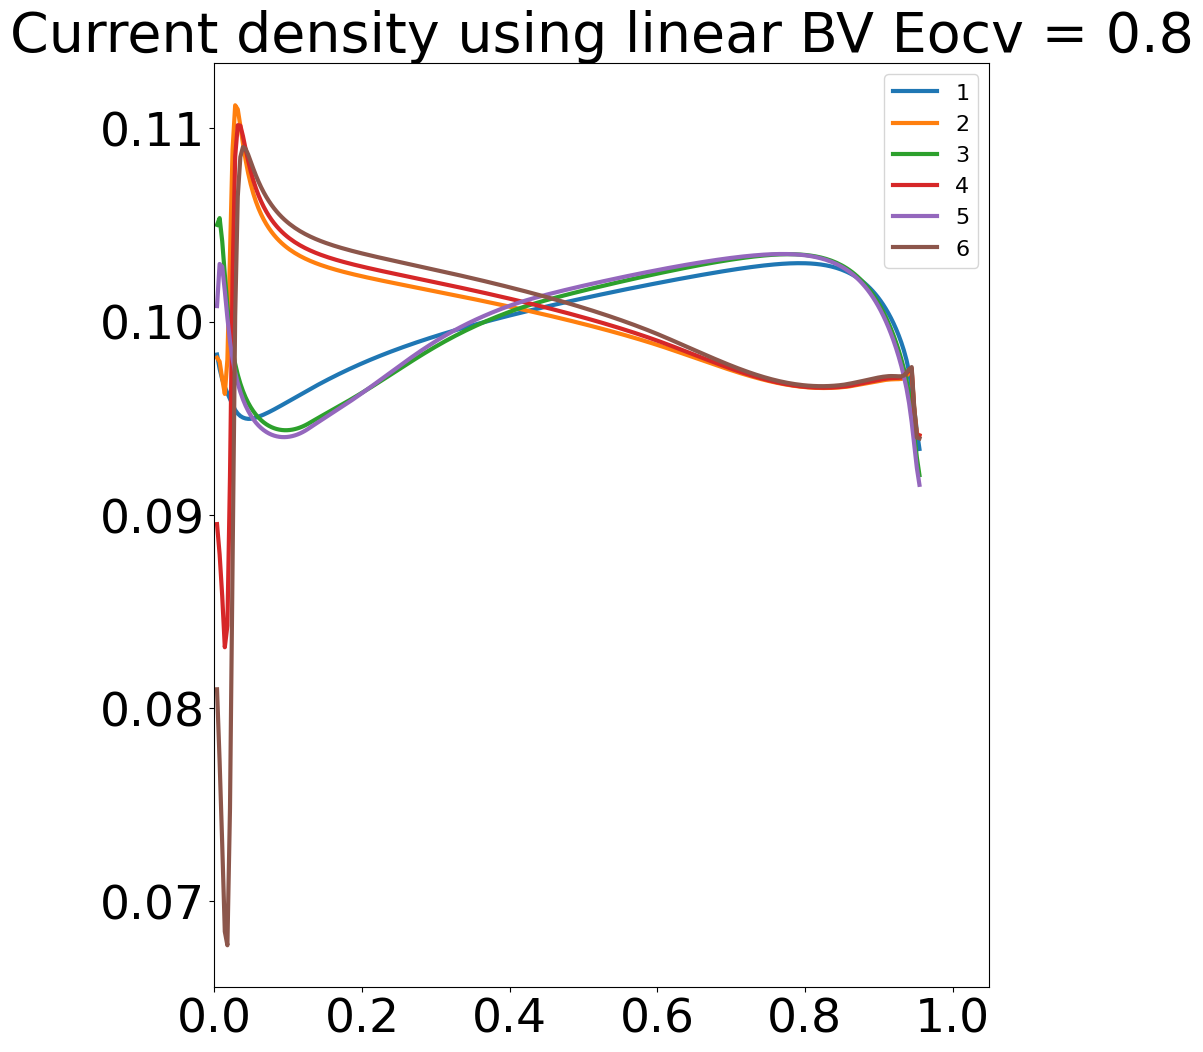

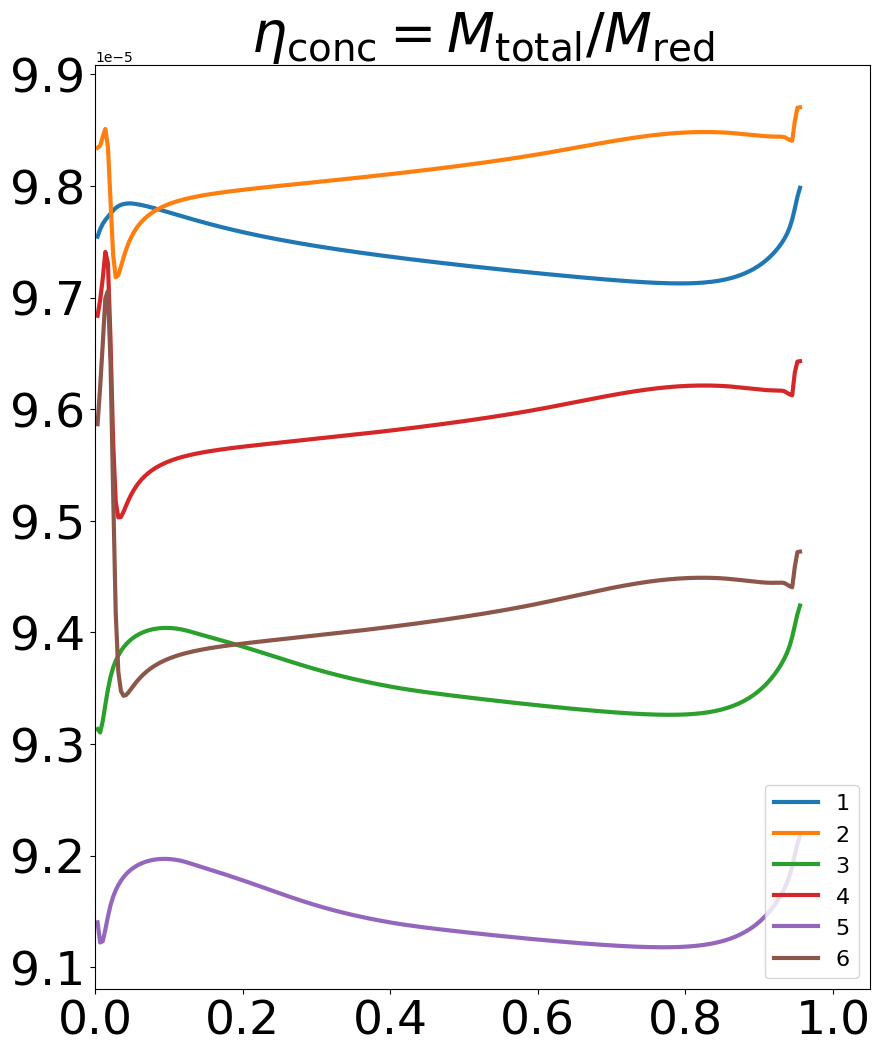

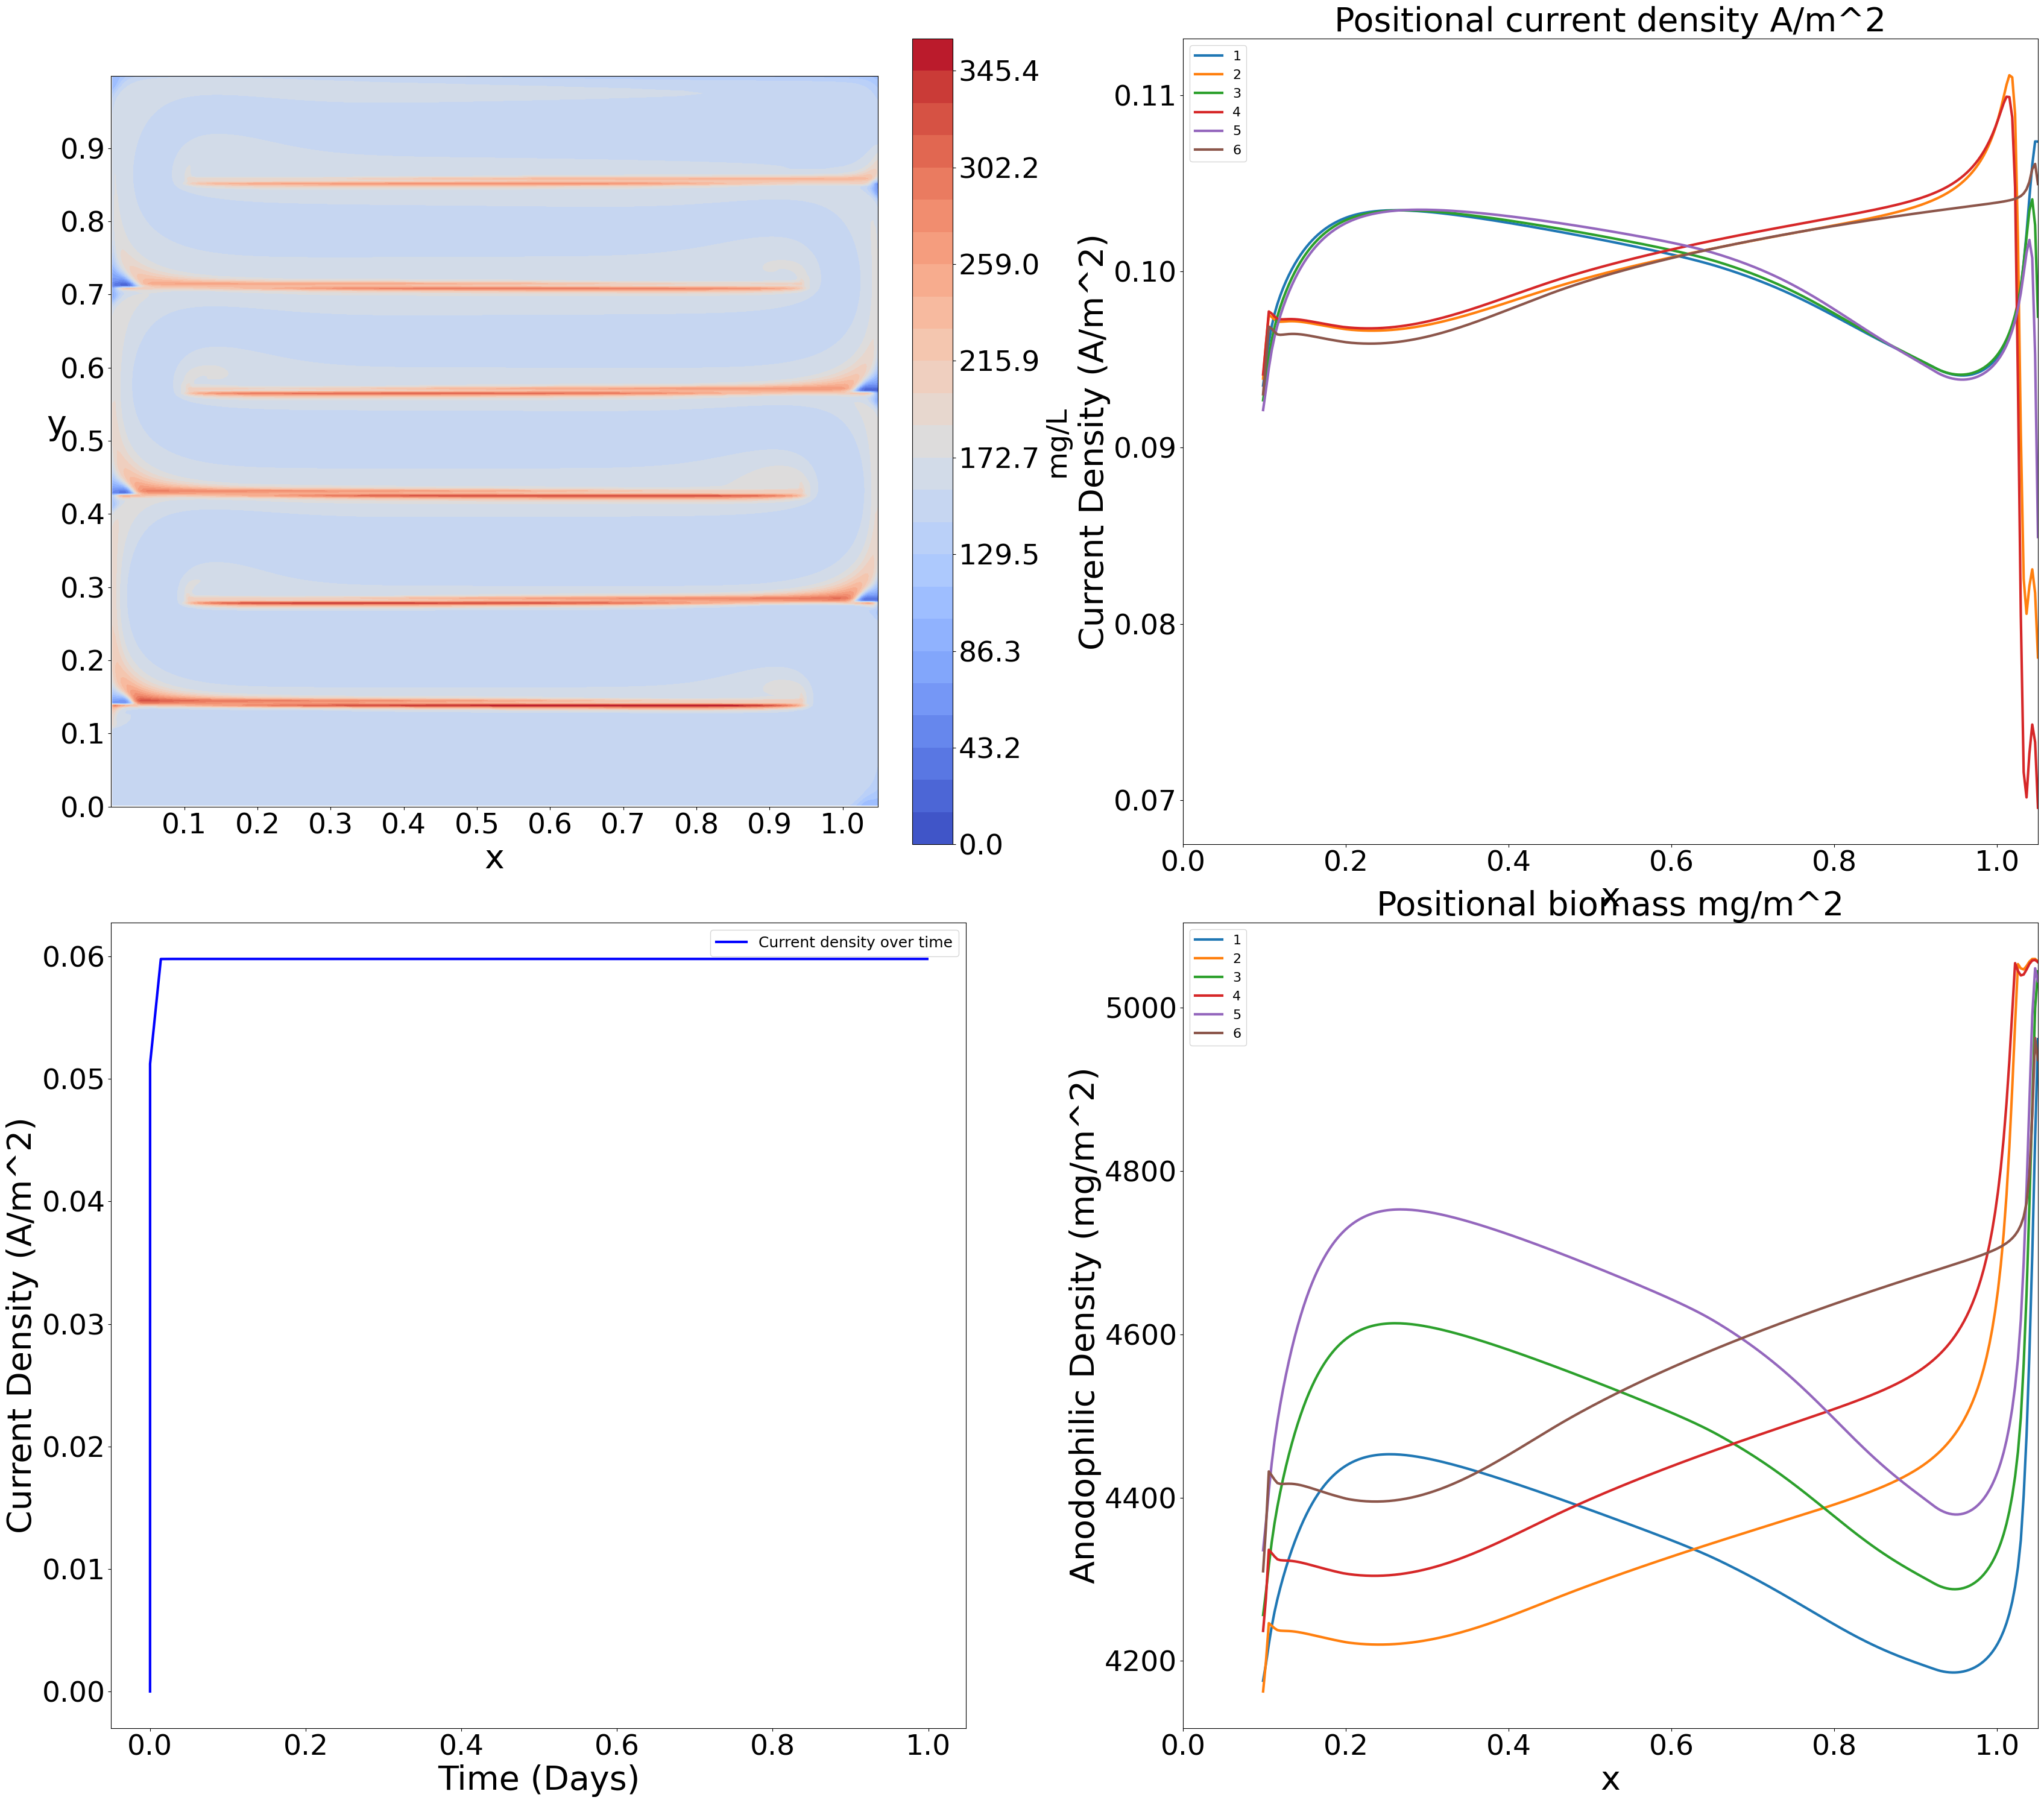

In [ ]:
# -*- coding: utf-8 -*-

# Copyright 2020 Jordan Day
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#


# import numpy as np
# import scipy as sp
from scipy import sparse
# from scipy.sparse import linalg
# import matplotlib.pyplot as plt
# import time
from tqdm import tqdm
from Fluid_classes import *
from Plotting_functions import *
import os
from pathlib import Path
import solver

np.random.seed(0)
nx = 300
ny = 300
nz = 1
Lx = 1.05  # length in m
Ly = 1  # length in m
Lz = 1.05  # length in m
hrt = 12  # hrt set in any given time units TC is the conversion to seconds
file_name = 'HRT_{}_ym_26_Three_Population_area_optimisation_side_'.format(int(hrt))  # File name to save output data

hrt *= TC_hour  # The hydraulic retention time converted into seconds
baffle_length = 91 / 100  # This is the fraction of the tank a baffle takes up in x
baffle_pairs = 3  # Number of baffle pairs (RHS+LHS) = 1 pair.

# Baffle param
rho = 8000
# Runtime for reactor system
RT = 1
RT *= TC_day
dt_max = 8
k = 20  # Store data every k min, 1 is every min, 2 every 2 min
D = 1 / hrt
anode_side = 'all'  # can either be 'all', 'influent', 'effluent' 'front_loaded' based on the layout you wish to test
file_name += anode_side
print(file_name)

dx = Lx / nx
dy = Ly / ny
x = np.linspace(0, Lx, nx).T
y = np.linspace(0, Ly, ny).T
[yy, xx] = np.meshgrid(np.linspace(dy / 2, Ly - dy / 2, ny), np.linspace(dx / 2, Lx - dx / 2, nx))

system = domain(Lx, Ly, Lz, nx=nx, ny=ny)

flux = (Lx * Ly) / hrt  # The "area flux" through the system
nxy = nx * ny
nxy_one = (nx + 1) * (ny + 1)
psi = np.zeros((nx + 1, ny + 1))  # This is the stream function
boundary = np.zeros((nx + 1, ny + 1))  # We set this to 1 on all boundary points
boundary[0, :] = 1
boundary[-1, :] = 1
boundary[:, 0] = 1
boundary[:, -1] = 1

edges = boundary
psi[0, 0:ny + 3] = flux
psi[:, -1] = flux
psi, boundary, in_out_points, in_start, out_start = system.influent_effluent_regions(baffle_pairs, baffle_length,
                                                                                     dy * 18, psi, boundary, flux)

bdata = psi[boundary == 1]

file_a = 'hrt' + str(hrt).replace('.', '_') + '_nx' + str(nx) + '_ny' + str(ny) + '_Lx' + str(Lx) + '_Ly' + str(
    Ly) + '_pairs' + str(baffle_pairs) + '_width' + str(np.round(baffle_length, decimals=1)).replace('.',
                                                                                                     '_') + '.csv'
file_x = 'Ux_' + file_a
file_y = 'Uy_' + file_a
data_folder = Path(os.getcwd(),'Velocity Fields')

try:
    ux = np.genfromtxt(data_folder / file_x, delimiter=',')
    uy = np.genfromtxt(data_folder / file_y, delimiter=',')
    print('Velocity Files loaded from text files')
except:
    psi, ux, uy, resid = solver.steady_state(boundary, psi, nx, ny, dx, dy,error=1e-6)  # Using function to determine steady state
    save_velocity_fields(file_a,['Velocity Fields'],ux,uy)
    print('Velocity fields have been determined and saved in text files \n')

# %%
external = np.zeros(boundary.shape)
external[0, :] = 1
external[-1, :] = 1
external[:, 0] = 1
external[:, -1] = 1
internal = boundary - external
bio_loc = np.zeros(boundary.shape)
bio_loc[:, 0:ny] += internal[:, 1:ny + 1]
bio_loc[:, 1:ny + 1] += internal[:, 0:ny]
bio_loc = bio_loc[0:nx, 0:ny]
if baffle_length == 0 and baffle_pairs == 0:
    bio_loc[1:-1, -2] = 1
    bio_loc[1:-1, 1] = 1

positional = np.nonzero(np.mean(bio_loc, 0))
switch = np.zeros(bio_loc.shape)
if anode_side == 'influent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][0:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('influent facing anodes are active')
elif anode_side == 'effluent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][1:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('effluent facing anodes are active')
elif anode_side == 'front_loaded':
    switch[:, positional[0][10:20:1]] = 1
    glucose_loc = 1 * bio_loc
    bio_loc *= switch
    #glucose_loc = glucose_loc - bio_loc
    print('First 5 carts are fermenting only')
else:
    anode_side = 'all'
    #switch[:, positional[0][11:20:1]] = 1
    #bio_loc *= switch
    glucose_loc = 1 * bio_loc
    print('All anodes are active')

bio_number = np.count_nonzero(bio_loc)
glucose_number = np.count_nonzero(glucose_loc)
# %%

anode_numbers = np.count_nonzero(np.mean(bio_loc, 0))

# Determine anode area based on biofilm and baffle length
Ai = dx * Lz
A = baffle_length * nx * Ai
# A = Lx * Lz #anode area
# Ai = A/nx # area per cell

Vol = Lx * Ly * Lz * 1e3  # Volume in
Voli = dx * dy * Lz * 1e3  # Local volume in L

convert_m2_l = Ai / Voli
convert_l_m2 = Voli / Ai

z1 = MicrobialPopulation(5000 * np.ones(bio_number)  # np.random.normal(loc = 1000,scale = 10,size = (nx,2)) #initial
                         , 7.9 / TC_day  #7.9 / TC_day  # consumption
                         , 2*0.7 / TC_day  # growth
                         , 0.02  # decay
                         , 20 # sub monod const
                         , 'Anodophilic'  # Defining anodophilic species as class
                         , 5000
                         , mediator_monod=0.2 * 1)

z3 = MicrobialPopulation(512 * np.ones(glucose_number)
                         , 8.3 / TC_day
                         , 2*0.3 / TC_day
                         , 0.02
                         , 80
                         , 'Methanogenic',
                         5000)

z2 = MicrobialPopulation( 2000 * np.ones(glucose_number)
                         , 4.8/ TC_day
                         , 2*0.4 / TC_day
                         , 0.02
                         , 100
                         , 'Glucose Consumer'
                         , 2000)

# Doubles initial bacteria conc on biofilms without electrogens
z2_space = 0*glucose_loc
z2_space[glucose_loc == 1] = z2.current
z2_space[glucose_loc - bio_loc == 1] = 4000
z2.current = z2_space[glucose_loc==1]

z3_space = 0*glucose_loc
z3_space[glucose_loc == 1] = z3.current
z3_space[glucose_loc - bio_loc == 1] = 2*z3.current.max()
z3.current = z3_space[glucose_loc==1]


s = Substrate(100 * np.ones((nx, ny)), influent=150, diffusion=1e-9, name='Acetate')
s.current = s.update_influent(baffle_pairs, in_out_points, ny)
s2 = Substrate(100* np.ones((nx, ny)),influent= 1500,diffusion= 1e-9,name = 'Glucose') # 300 or 1500
s2.current = s2.update_influent(baffle_pairs, in_out_points, ny)
s2.s_yield = 0.7 ################################################### Latest run using 0.8 as Ac yield

m_total = 1  # mg-M / mg-Z Initial mediator

mox = Parameters(0.99 * m_total * np.ones(bio_number), name='Oxidised Mediator')

mred = Parameters(m_total - mox.initial, name='Reduced Mediator')
Ym = 26#22.75  # mg-M /mg -s 36#32
m = 2  # mol-e / mol-M
gamma = 663400  # mg-M/mol-M
T = 298  # K
j0 = 1#e-2  # 1e-2-> almost identical to 1, but much faster run times
BV_full = False

j_min = 1.60
j_max = 1.60  # 1.34#0.64
##############################################
# changed here and j_0 ###
E_min_scaled = j_min * (A * 500)  # /(R*T/(m*F*j0))Anode area times sum of res
E_max_scaled = j_max * (A * 500)  # /(R*T/(m*F*j0)) Anode area times sum of res

#############################################
j_test = 1.5  # .4#2.4#1.6#2.4/10  # 40 j0 = 1e-4
# Full BV stable for hrt = 2, 6, j0 = 1e-4 , J_test = 1.4

Rin = Parameters(0, minimum=7, maximum=7, k=0.006 * A / Vol, name='Internal Resistance')
Rex = 1  # ohm
E_test = 0.8  # j_test * (A * (Rin.minimum+Rex)) # j_test*(R*T/(m*F*j0)+500*A*(0.92/0.08)/(0.92/0.08))

E = Parameters(0, minimum=E_test, maximum=E_test, k=0.0006, name='Voltage')
# E = Parameters(0, minimum=10, maximum=10, k=0.0006, name='Voltage')

# E_ocv = E_test * bio_loc
# E_ocv[:,270:273:2] = 0.9*(A * (Rin.minimum+Rex))
# E_ocv = E_ocv[bio_loc == 1]
# E.current = E_ocv


pref = gamma / (m * F)
I = Parameters(0, name='Current (Not to be confused with current value)')
s_blank = np.zeros((bio_number, 5000))
ij = 0
t = GeneralVariable(0, name='Time')
Rin.current = Rin.minimum  # +(Rin.maximum - Rin.minimum)*np.exp(-Rin.k*sum(z1.initial)/nx) + Rex
Rin.storage[0] = Rin.current

# setting up locations for biofilm
# bio_loc = np.zeros((nx,ny))
bio_upper = np.zeros((nx, ny))
bio_lower = np.zeros((nx, ny))
bio_lower[:, -2] = 1  # used for plotting
bio_upper[:, 1] = 1
consump = np.zeros((nx, ny))  # setting consumption array
med_dist = np.zeros(consump.shape)

ux_max = np.max(ux)  # max velocity based on steady state
uy_max = np.max(uy)  # max vel from steady state
# Creating sparse matrix for biofiolm diffusion]
positions = [-1, 0, 1]
diag_x = np.array([[1 / (dx ** 2)], [-2 / (dx ** 2)], [1 / (dx ** 2)]]).repeat(nx, axis=1)
diag_y = np.array([[1 / (dy ** 2)], [-2 / (dy ** 2)], [1 / (dy ** 2)]]).repeat(ny, axis=1)
Dx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # d/dx mat Alternate approach to using diffuse_S array
Dy = sp.sparse.spdiags(diag_y, positions, ny, ny)  # d/dy mat
kappa_bio = 1e-12  # diffusion rate for biofilm
Dx_bio = sp.sparse.spdiags(diag_x, positions, nx, nx).tolil()
Dx_bio[0, -1] += 1 / (dx ** 2)  # Periodic Boundary Conditions
Dx_bio[-1, 0] += 1 / (dx ** 2)  # Periodic BC
# Dx_bio[0,-1] += 1/(dx**2) # non peridoic bc
# Dx_bio[0,-1] += 1/(dx**2) # Need to fix
Dx_bio *= kappa_bio  # setting up diffusion array for biofilm
Dx_bio = Dx_bio.tocsr()

Bx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # tolil()
By = sp.sparse.spdiags(diag_y, positions, ny, ny)
Iy = sp.sparse.eye(ny)
Ix = sp.sparse.eye(nx)
Diffuse_s = (sp.sparse.kron(Iy, Bx) + sp.sparse.kron(By, Ix)).tolil()

bio_diffusion_x = sp.sparse.kron(Iy, Bx).tolil()
temp_location = np.zeros((nx + 1, ny + 1))
temp_location[:-1, :-1] = bio_loc

for ii in np.arange(nxy):
    ix = int(ii % nx)
    iy = int(np.floor(ii / nx))
    jj = iy * (nx + 1) + ix
    if boundary[ix, iy] * boundary[ix, iy + 1] == 1:  # Boundary on left
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dx ** 2)  #
        if ix != 0:
            Diffuse_s[ii, ii - 1] = 0
    if boundary[ix + 1, iy] * boundary[ix + 1, iy + 1] == 1:  # Boundary on right
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dx ** 2)
        if ix != nx - 1:
            Diffuse_s[ii, ii + 1] = 0

    if boundary[ix, iy] * boundary[ix + 1, iy] == 1:  # Boundary below
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != 0:
            Diffuse_s[ii, ii - nx] = 0

    if boundary[ix, iy + 1] * boundary[ix + 1, iy + 1] == 1:  # Boundary above
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != ny - 1:
            Diffuse_s[ii, ii + nx] = 0
    if temp_location[ix, iy] * temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix != 0:
        if temp_location[ix - 1, iy] * temp_location[ix, iy] == 0:
            bio_diffusion_x[ii, ii] += 1 / (dx ** 2)

    if temp_location[ix, iy] + temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] -= 1 / (dx ** 2)

Diffuse_s = Diffuse_s.tocsr()
LU = sp.sparse.linalg

bio_diffusion_x = 0*1e-9 * bio_diffusion_x.tocsr()
z1.biomass_diffusion(bio_loc,bio_diffusion_x)
z2.biomass_diffusion(glucose_loc,bio_diffusion_x)
z3.biomass_diffusion(glucose_loc,bio_diffusion_x)



z1.calculate_positional_distribution(bio_loc)
temp = bio_diffusion_x.dot(np.reshape(z1.positional_distribution.T, nxy))
temp = np.reshape(temp.T, (ny, nx)).T
temp[bio_loc != 1] = 0  # Deals with mass produced outside of biofilm! (temp fix)

del temp_location

s.storage[:, :, 0] = s.initial
s.current[:, :] = s.initial  # This line causes s.initial to be linked to s.now

dt = min(dt_max, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
        2 * s.diffusion * (dx ** 2 + dy ** 2)))
# dt = np.floor(dt*100)/100

ii = 0
rk = np.array([[0, 1 / 2, 1 / 2, 1], [0, 1, 1, 1], [1, 2, 2, 1]]).T
bound_out = np.zeros(s.current.shape)
bound_in = np.zeros(s.current.shape)
bound_out[-1, :] = 1
bound_out[:, -1] = 1
bound_out[:, 0] = 1
bound_in[-2, :] = 1
bound_in[:, -2] = 1
bound_in[:, 1] = 1

E.current = E.minimum
Rin.current = Rin.minimum
Rsig = Rin.current + Rex

mred.current = m_total - mox.current
eta_conc = R * T / (m * F) * np.log(m_total / mred.current)

med_dist[bio_loc == 1] = Ai * mred.current / mox.current
summation = np.array([Rsig * np.sum(med_dist, 0), ] * nx)
summation_shaped = summation[bio_loc == 1]
j = (mred.current / mox.current * (E.current - eta_conc)) / (
        R * T / (m * F * j0) + summation_shaped)
del eta_conc

print("System will simulate a {} baffle system with a fluid HRT of {} hours and bio runtime of {} days".format(
    2 * baffle_pairs, hrt / TC_hour, RT / TC_day))

start_time_bio = time.time()
storage_steps = int(k * 60 / dt)
z1.diffused *= 0
z2.diffused *= 0
z2.diffused *= 0
combined_max = 8000
total_time = time.time()
pbar = tqdm(total=101, desc="Progress of simulation", ncols=100, )

fermenting_bio_loc = glucose_loc - bio_loc

while t.current < RT + 10:
    ii += 1
    lt = time.time()
    irk = 0
    consump *= 0  # Reset consumption
    while irk < 4:  # replaced with while loop to allow for adaptive timesteps
        if irk == 0:
            z1.intermediate = z1.current
            z3.intermediate = z3.current
            s.intermediate = s.current
            mox.intermediate = mox.current
            mred.intermediate = m_total - mox.intermediate

            z2.intermediate = z2.current
            s2.intermediate = s2.current
        else:
            z1.update_intermediate(rk, irk, dt)
            z3.update_intermediate(rk, irk, dt)
            s.update_intermediate(rk, irk, dt)
            mox.update_intermediate(rk, irk, dt)
            mred.intermediate = m_total - mox.intermediate

            s.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s.influent

            z2.update_intermediate(rk, irk, dt)
            s2.update_intermediate(rk, irk, dt)
            s2.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s2.influent



        if (mox.current + (dt / 6) * mox.ddt2 > m_total).any() or (
                mox.current + rk[irk, 0] * dt * mox.ddt1 > m_total).any():
            # If over estimating rk4 loop is reset with smaller timestep
            irk = 0
            dt *= 0.5
            continue


        local_g = np.reshape(s2.intermediate[glucose_loc == 1], (glucose_number))
        z2.update_growth_and_consumption(local_g)
        z2.first_timestep()
        z2.second_timestep(rk, irk)

        local_s = np.reshape(s.intermediate[bio_loc == 1], bio_number)
        local_s_meth = np.reshape(s.intermediate[glucose_loc == 1], (glucose_number))

        substrate_mean_surface = anode_surface_sum(Ai * local_s, bio_loc) / A

        j, eta_act = current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
        I_anode = anode_surface_sum_repeated(j * Ai, bio_loc)
        mediator_current_density_term = I_anode / A

        # local_s = np.reshape(s.intermediate[bio_loc == 1], (bio_number))
        z1.update_growth_and_consumption(local_s, mox.intermediate)
        z3.update_growth_and_consumption(local_s_meth)
        # diff_z1 = 0  # *Dx_bio.dot(vdata1[0,])
        # diff_z3 = 0  # *Dx_bio.dot(vdata1[1,]) # diffusion of X and Z
        z1.biomass_diffusion(bio_loc, bio_diffusion_x)
        z3.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z2.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z1.first_timestep()
        z1.second_timestep(rk, irk)
        z3.first_timestep()
        z3.second_timestep(rk, irk)
        mox.ddt1 = -Ym * z1.consumption + pref * j / z1.intermediate
        mox.second_timestep(rk, irk)
        s.calculate_advection(ux, uy, dx, dy)  # Advection is slowest process
        s.calculate_diffusion(Diffuse_s)  # diff is second slowest
        s.calculate_consumption(z1, z3, biofilm_location=bio_loc, convert_m2_l=convert_m2_l,biofilm_location2=glucose_loc)  # rapid
        fluid_time = time.time()
        s.first_timestep()  # Timestepping is almost as slow as diff
        s.created = -s2.s_yield * s2.consumption
        s.ddt1 += s.created
        s.second_timestep(rk, irk)
        s2.calculate_advection(ux, uy, dx, dy)
        s2.calculate_diffusion(Diffuse_s)
        s2.calculate_consumption(z2, biofilm_location=glucose_loc, convert_m2_l=convert_m2_l)
        s2.first_timestep()
        s2.second_timestep(rk, irk)
        irk += 1  # move forward in rk4 loop
        if irk == 4 and (mox.current + (dt / 6) * mox.ddt2 > m_total).any():
            irk = 0
            dt *= 0.5
            # print('Loop restart')
            continue

    z2.update_current(dt)
    s2.update_current(dt)

    z1.update_current(dt)
    z3.update_current(dt)
    s.update_current(dt)
    mox.update_current(dt)
    mred.current = m_total - mox.current

    j, eta_act, eta_conc = current_density(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
    I.current = np.sum(Ai * j)
    t.current += dt
    dt = min(dt_max, dt * 2, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
            2 * s.diffusion * (dx ** 2 + dy ** 2)))  # increase timestep up to 2 or double previous timestep
    s.current = s.update_influent(baffle_pairs, in_out_points, ny)
    z2.calculate_positional_distribution(glucose_loc)
    z3.calculate_positional_distribution(glucose_loc)
    temp_shared1 = z2.positional_distribution[bio_loc == 1]
    temp_shared2 = z3.positional_distribution[bio_loc == 1]
    total_biomass = z1.current + temp_shared1 + temp_shared2#+ z2.current
    if (total_biomass > rho).any():
        z1.current[total_biomass > rho] *= rho/total_biomass[total_biomass > rho]
        temp_shared1[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        temp_shared2[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        z2.positional_distribution[bio_loc == 1] = temp_shared1
        z3.positional_distribution[bio_loc == 1] = temp_shared2


    temp_mass1 = z2.positional_distribution[fermenting_bio_loc == 1]
    temp_mass2 = z3.positional_distribution[fermenting_bio_loc == 1]
    total_biomass2 = temp_mass1 + temp_mass2
    if (total_biomass2 > rho).any():
        temp_mass1[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        temp_mass2[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        z2.positional_distribution[fermenting_bio_loc == 1] = temp_mass1
        z3.positional_distribution[fermenting_bio_loc == 1] = temp_mass2

    z2.current = z2.positional_distribution[glucose_loc == 1]
    z3.current = z3.positional_distribution[glucose_loc == 1]

    if ii % storage_steps == 0 or ii == 1:  # round(t.now,2)%(k*60) == 0 : #Storage of data
        ij += 1
        z1.storage[:, ij] = z1.current
        z3.storage[:, ij] = z3.current
        mox.storage[:, ij] = mox.current
        mred.storage[:, ij] = mred.current
        I.storage[ij] = I.current
        t.storage[ij] = t.current
        s.storage[:, :, ij] = s.current
        s_blank[:, ij] = z1.storage[:,ij-1] - z1.storage[:,ij]  # (muz-Kda)*vdata[0,]
        z2.storage[:,ij] = z2.current
        s2.storage[:,:,ij] = s2.current

        increase = round((t.current - t.storage[ij - 1]) / (RT + 20) * 100, 1)
        pbar.update(round(increase, 1))

#

gl_removal_percent = (s2.influent - mean_effluent(s2,in_out_points,out_start))/s2.influent*100
s_removal_percent = (s.influent - mean_effluent(s,in_out_points,out_start))/s.influent*100
influent_cod = s2.influent*1.07+s.influent*1.06
effluent_cod = mean_effluent(s2,in_out_points,out_start)*1.07 + mean_effluent(s,in_out_points,out_start)*1.06
cod_removal_percent = (influent_cod - effluent_cod)/influent_cod*100
print('\n HRT: {} hours\n Glucose removal percent: {} \n Acetate removal percent: {} \n COD removal percent: {} \n Current Density: {} \n'.format(hrt/TC_hour,
    gl_removal_percent,s_removal_percent,cod_removal_percent,j.mean()))

#save_data_classes_two_substrates(file_name,['Output','temp'],s,z1,mox,mred,j,t,s2,z2)
save_data_classes_two_substrates(file_name,['Output','Three_Population_Files'],s,z1,mox,mred,j,t,s2,z2,z3)

z1.update_mean(0)
z2.update_mean(0)
z3.update_mean(0)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average),sty = 'r--',linelabel = 'Glucose Consumer',new_fig=True)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z1.average),sty = 'g-',linelabel = 'Anodophilic',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z3.average),sty = 'k-',linelabel = 'Methanogen',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average+z1.average+z3.average),sty = 'b.--',linelabel = 'Total',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )

print(t.current)
plot_positional_data(x, j, bio_loc, new_fig=True)

print(current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=False))
current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=True)

print(dt, t.current)
plot_positional_data(x, j, bio_loc, new_fig=True, side='Left',
                     title='Current density using linear BV Eocv = {}'.format(E.current))

plot_positional_data(x, eta_conc, bio_loc, side='left', new_fig=True,
                     title='$\eta_\mathrm{conc} = M_\mathrm{total}/M_\mathrm{red}$')

plt.figure(figsize=(34, 30))
plt.subplot(221)
plot_contour(xx, yy, s.current)
plt.subplot(222)
plot_positional_data(x, j, bio_loc, side='right', title='Positional current density A/m^2',ylab = 'Current Density (A/m^2)',xlab = 'x')
plt.subplot(223)
plot_time_series(t.storage[0:ij + 1] / TC_day, I.storage[0:ij + 1] / (20 * A), linelabel='Current density over time',ylab = 'Current Density (A/m^2)',xlab = 'Time (Days)')
plt.subplot(224)
plot_positional_data(x, z1.current, bio_loc, side='right', title='Positional biomass mg/m^2',ylab = 'Anodophilic Density (mg/m^2)',xlab = 'x')


HRT_6_ym_26_Three_Population_area_optimisation_side_all
Velocity Files loaded from text files
All anodes are active
System will simulate a 6 baffle system with a fluid HRT of 6.0 hours and bio runtime of 1.0 days


Progress of simulation: 100%|█████████████████████▉| 100.80000000000011/101 [49:37<00:06, 31.16s/it]


 HRT: 6.0 hours
 Glucose removal percent: 2.3709815619673464 
 Acetate removal percent: -6.2382704966644456 
 COD removal percent: 1.5949775498797822 
 Current Density: 0.10002633902388659 

86411.78242396971
(array([0.09879089, 0.10829297, 0.10515496, ..., 0.10364008, 0.11007779,
       0.10647981]), array([9.94318718e-06, 1.09704478e-05, 1.03968736e-05, ...,
       1.03465689e-05, 1.06081131e-05, 1.05184083e-05]))
2.2407951254826703 86411.78242396971
Supply both Ux and Uy data to overlay streamlines
Supply both scatter positions and data to overlay scatter density


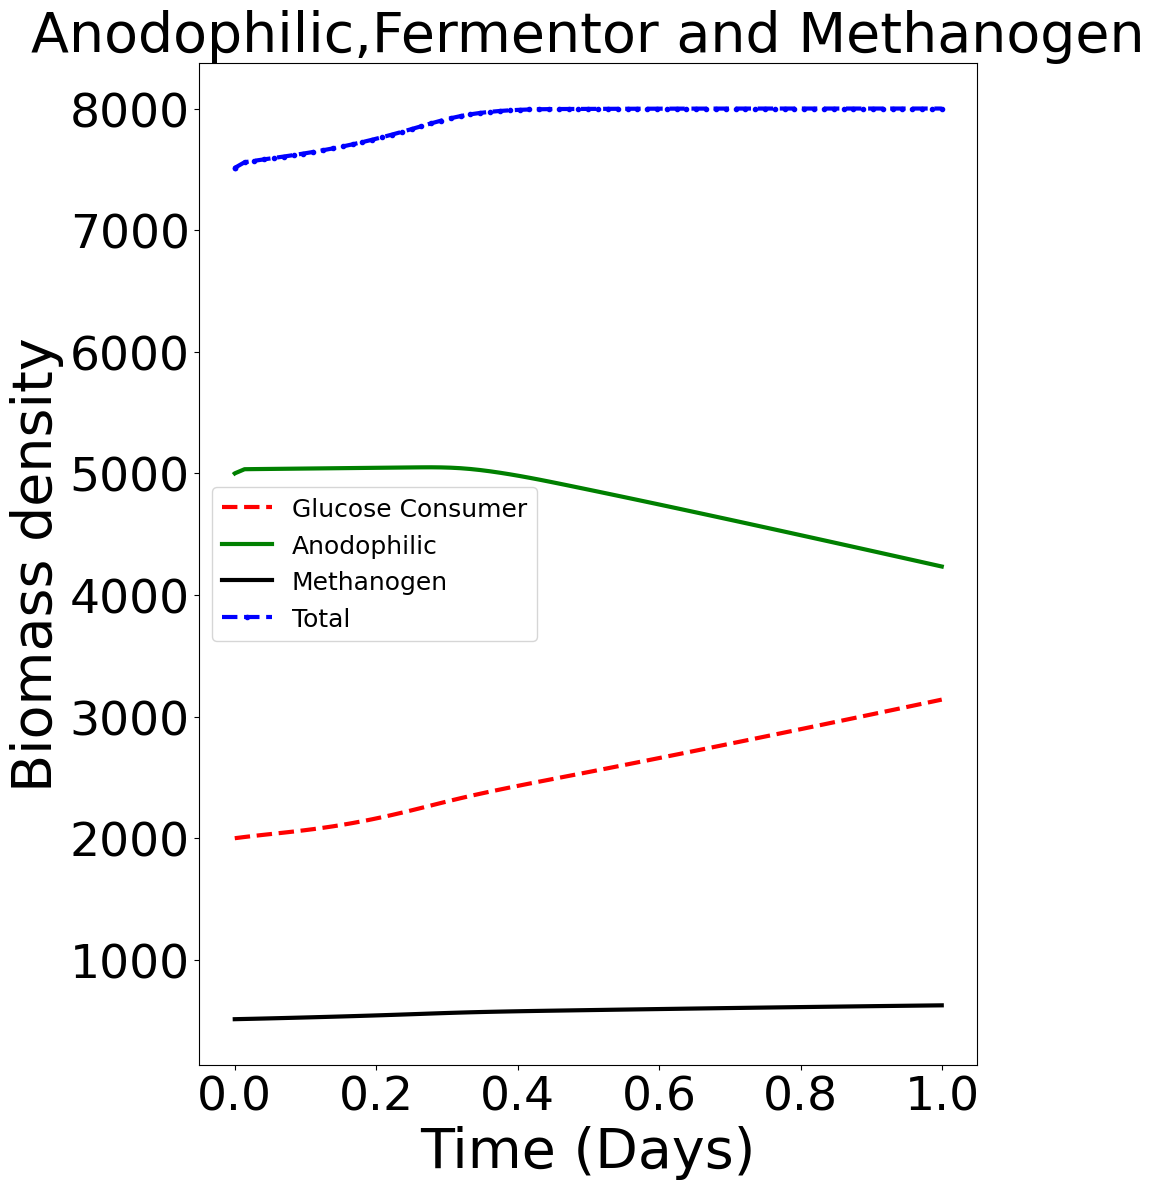

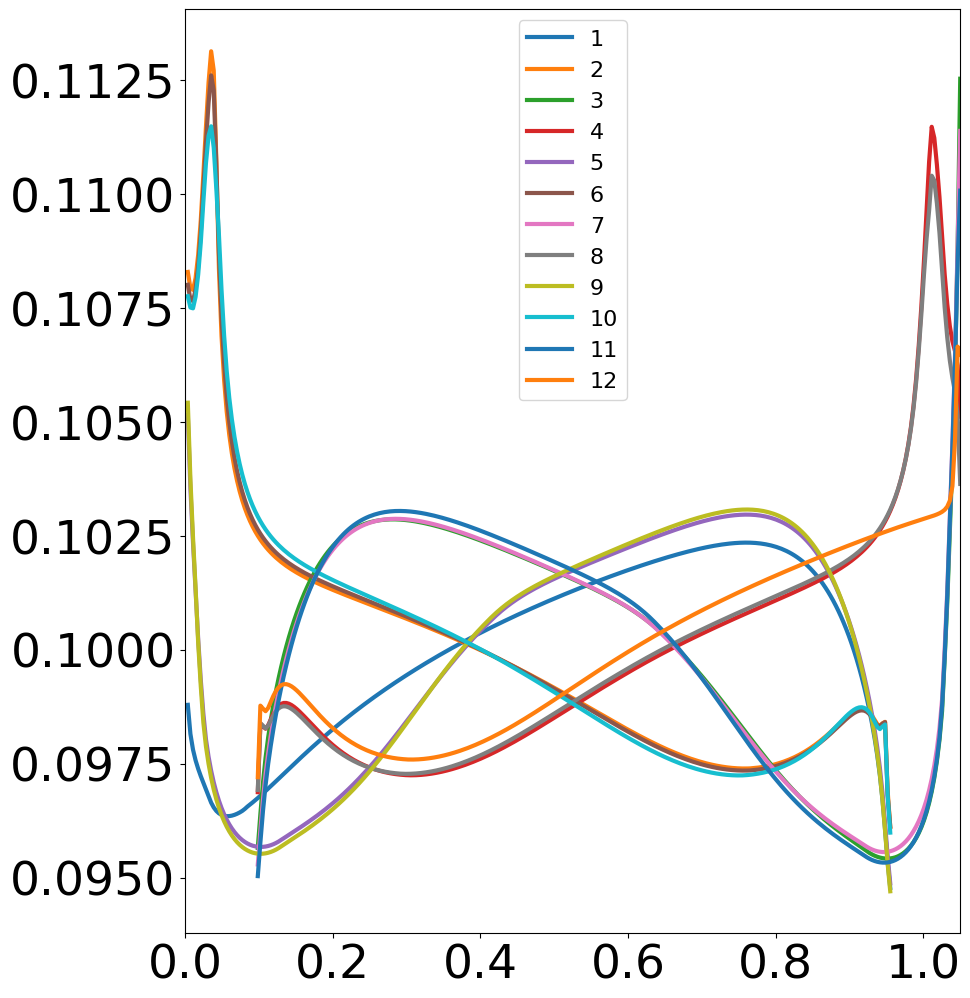

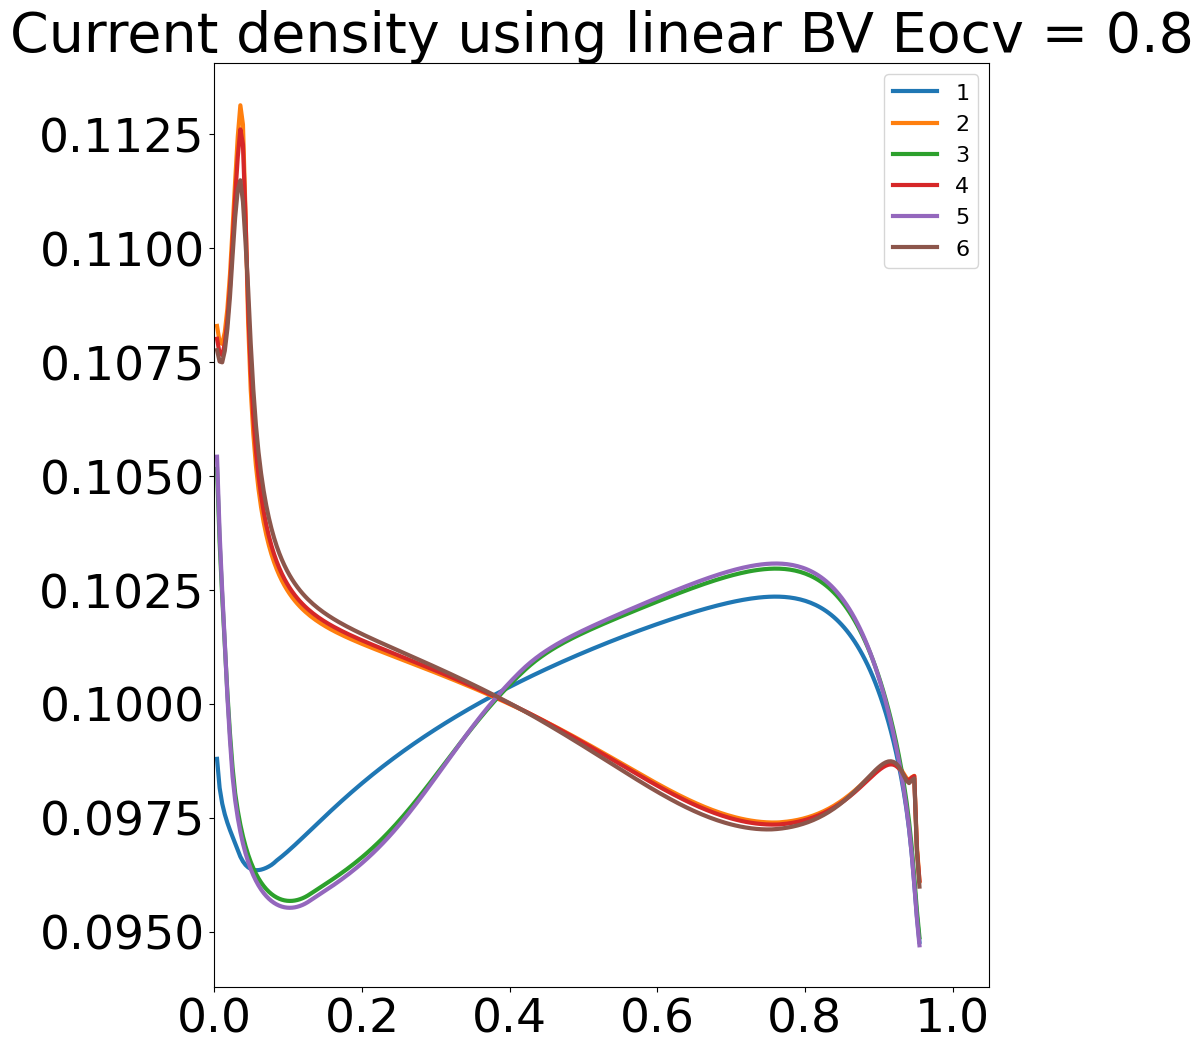

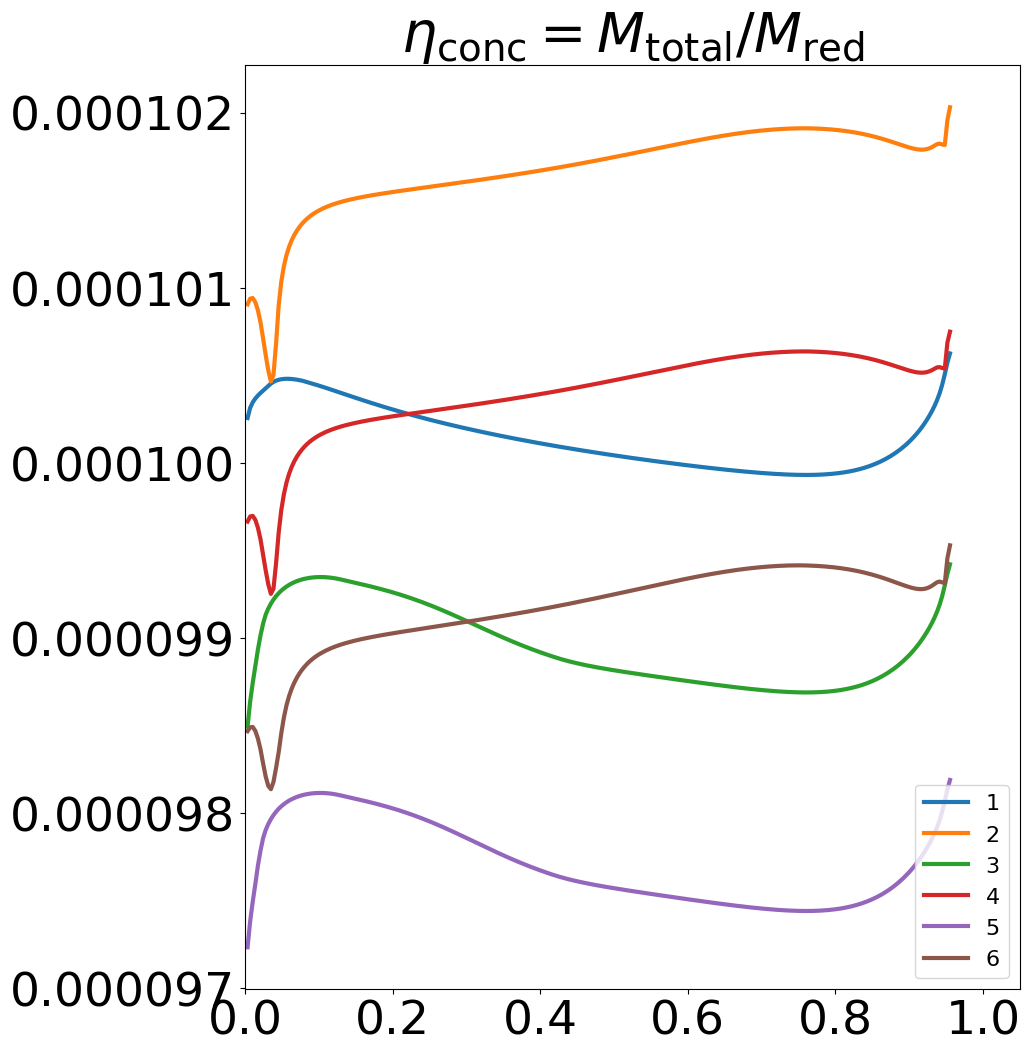

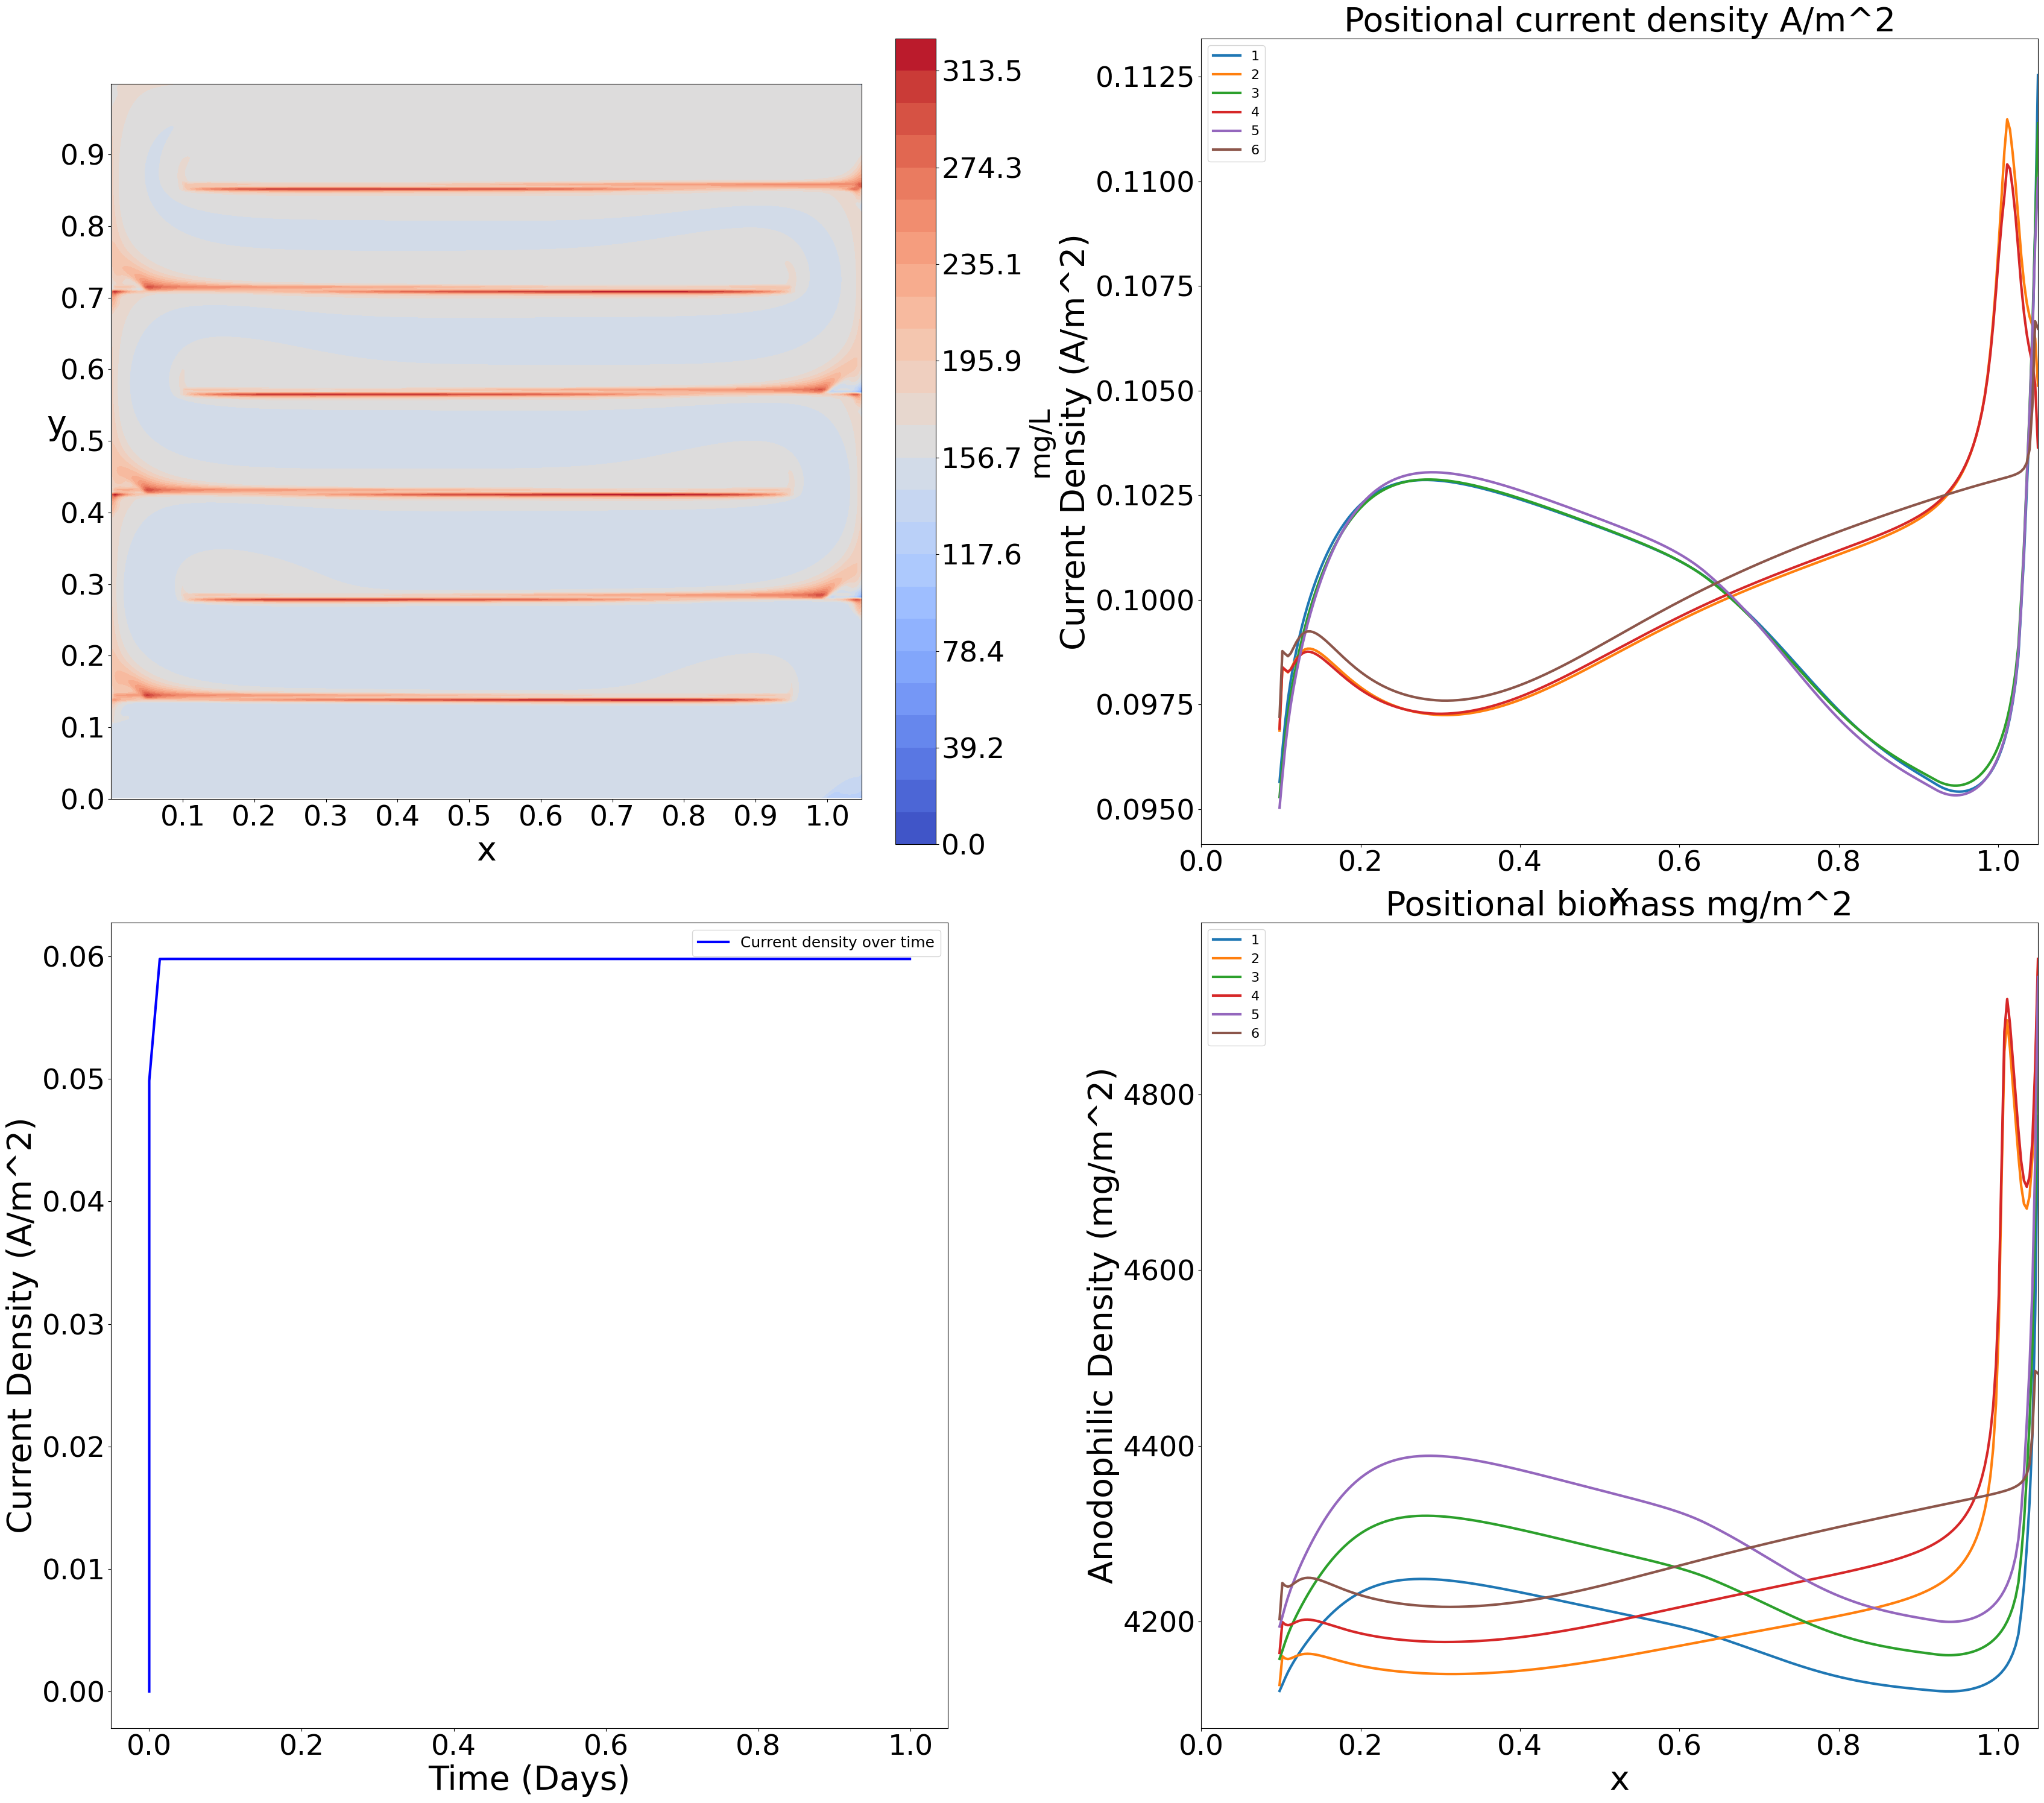

In [ ]:
# -*- coding: utf-8 -*-

# Copyright 2020 Jordan Day
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#


# import numpy as np
# import scipy as sp
from scipy import sparse
# from scipy.sparse import linalg
# import matplotlib.pyplot as plt
# import time
from tqdm import tqdm
from Fluid_classes import *
from Plotting_functions import *
import os
from pathlib import Path
import solver

np.random.seed(0)
nx = 300
ny = 300
nz = 1
Lx = 1.05  # length in m
Ly = 1  # length in m
Lz = 1.05  # length in m
hrt = 6  # hrt set in any given time units TC is the conversion to seconds
file_name = 'HRT_{}_ym_26_Three_Population_area_optimisation_side_'.format(int(hrt))  # File name to save output data

hrt *= TC_hour  # The hydraulic retention time converted into seconds
baffle_length = 91 / 100  # This is the fraction of the tank a baffle takes up in x
baffle_pairs = 3  # Number of baffle pairs (RHS+LHS) = 1 pair.

# Baffle param
rho = 8000
# Runtime for reactor system
RT = 1
RT *= TC_day
dt_max = 8
k = 20  # Store data every k min, 1 is every min, 2 every 2 min
D = 1 / hrt
anode_side = 'all'  # can either be 'all', 'influent', 'effluent' 'front_loaded' based on the layout you wish to test
file_name += anode_side
print(file_name)

dx = Lx / nx
dy = Ly / ny
x = np.linspace(0, Lx, nx).T
y = np.linspace(0, Ly, ny).T
[yy, xx] = np.meshgrid(np.linspace(dy / 2, Ly - dy / 2, ny), np.linspace(dx / 2, Lx - dx / 2, nx))

system = domain(Lx, Ly, Lz, nx=nx, ny=ny)

flux = (Lx * Ly) / hrt  # The "area flux" through the system
nxy = nx * ny
nxy_one = (nx + 1) * (ny + 1)
psi = np.zeros((nx + 1, ny + 1))  # This is the stream function
boundary = np.zeros((nx + 1, ny + 1))  # We set this to 1 on all boundary points
boundary[0, :] = 1
boundary[-1, :] = 1
boundary[:, 0] = 1
boundary[:, -1] = 1

edges = boundary
psi[0, 0:ny + 3] = flux
psi[:, -1] = flux
psi, boundary, in_out_points, in_start, out_start = system.influent_effluent_regions(baffle_pairs, baffle_length,
                                                                                     dy * 18, psi, boundary, flux)

bdata = psi[boundary == 1]

file_a = 'hrt' + str(hrt).replace('.', '_') + '_nx' + str(nx) + '_ny' + str(ny) + '_Lx' + str(Lx) + '_Ly' + str(
    Ly) + '_pairs' + str(baffle_pairs) + '_width' + str(np.round(baffle_length, decimals=1)).replace('.',
                                                                                                     '_') + '.csv'
file_x = 'Ux_' + file_a
file_y = 'Uy_' + file_a
data_folder = Path(os.getcwd(),'Velocity Fields')

try:
    ux = np.genfromtxt(data_folder / file_x, delimiter=',')
    uy = np.genfromtxt(data_folder / file_y, delimiter=',')
    print('Velocity Files loaded from text files')
except:
    psi, ux, uy, resid = solver.steady_state(boundary, psi, nx, ny, dx, dy,error=1e-6)  # Using function to determine steady state
    save_velocity_fields(file_a,['Velocity Fields'],ux,uy)
    print('Velocity fields have been determined and saved in text files \n')

# %%
external = np.zeros(boundary.shape)
external[0, :] = 1
external[-1, :] = 1
external[:, 0] = 1
external[:, -1] = 1
internal = boundary - external
bio_loc = np.zeros(boundary.shape)
bio_loc[:, 0:ny] += internal[:, 1:ny + 1]
bio_loc[:, 1:ny + 1] += internal[:, 0:ny]
bio_loc = bio_loc[0:nx, 0:ny]
if baffle_length == 0 and baffle_pairs == 0:
    bio_loc[1:-1, -2] = 1
    bio_loc[1:-1, 1] = 1

positional = np.nonzero(np.mean(bio_loc, 0))
switch = np.zeros(bio_loc.shape)
if anode_side == 'influent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][0:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('influent facing anodes are active')
elif anode_side == 'effluent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][1:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('effluent facing anodes are active')
elif anode_side == 'front_loaded':
    switch[:, positional[0][10:20:1]] = 1
    glucose_loc = 1 * bio_loc
    bio_loc *= switch
    #glucose_loc = glucose_loc - bio_loc
    print('First 5 carts are fermenting only')
else:
    anode_side = 'all'
    #switch[:, positional[0][11:20:1]] = 1
    #bio_loc *= switch
    glucose_loc = 1 * bio_loc
    print('All anodes are active')

bio_number = np.count_nonzero(bio_loc)
glucose_number = np.count_nonzero(glucose_loc)
# %%

anode_numbers = np.count_nonzero(np.mean(bio_loc, 0))

# Determine anode area based on biofilm and baffle length
Ai = dx * Lz
A = baffle_length * nx * Ai
# A = Lx * Lz #anode area
# Ai = A/nx # area per cell

Vol = Lx * Ly * Lz * 1e3  # Volume in
Voli = dx * dy * Lz * 1e3  # Local volume in L

convert_m2_l = Ai / Voli
convert_l_m2 = Voli / Ai

z1 = MicrobialPopulation(5000 * np.ones(bio_number)  # np.random.normal(loc = 1000,scale = 10,size = (nx,2)) #initial
                         , 7.9 / TC_day  #7.9 / TC_day  # consumption
                         , 2*0.7 / TC_day  # growth
                         , 0.02  # decay
                         , 20 # sub monod const
                         , 'Anodophilic'  # Defining anodophilic species as class
                         , 5000
                         , mediator_monod=0.2 * 1)

z3 = MicrobialPopulation(512 * np.ones(glucose_number)
                         , 8.3 / TC_day
                         , 2*0.3 / TC_day
                         , 0.02
                         , 80
                         , 'Methanogenic',
                         5000)

z2 = MicrobialPopulation( 2000 * np.ones(glucose_number)
                         , 4.8/ TC_day
                         , 2*0.4 / TC_day
                         , 0.02
                         , 100
                         , 'Glucose Consumer'
                         , 2000)

# Doubles initial bacteria conc on biofilms without electrogens
z2_space = 0*glucose_loc
z2_space[glucose_loc == 1] = z2.current
z2_space[glucose_loc - bio_loc == 1] = 4000
z2.current = z2_space[glucose_loc==1]

z3_space = 0*glucose_loc
z3_space[glucose_loc == 1] = z3.current
z3_space[glucose_loc - bio_loc == 1] = 2*z3.current.max()
z3.current = z3_space[glucose_loc==1]


s = Substrate(100 * np.ones((nx, ny)), influent=150, diffusion=1e-9, name='Acetate')
s.current = s.update_influent(baffle_pairs, in_out_points, ny)
s2 = Substrate(100* np.ones((nx, ny)),influent= 1500,diffusion= 1e-9,name = 'Glucose') # 300 or 1500
s2.current = s2.update_influent(baffle_pairs, in_out_points, ny)
s2.s_yield = 0.7 ################################################### Latest run using 0.8 as Ac yield

m_total = 1  # mg-M / mg-Z Initial mediator

mox = Parameters(0.99 * m_total * np.ones(bio_number), name='Oxidised Mediator')

mred = Parameters(m_total - mox.initial, name='Reduced Mediator')
Ym = 26#22.75  # mg-M /mg -s 36#32
m = 2  # mol-e / mol-M
gamma = 663400  # mg-M/mol-M
T = 298  # K
j0 = 1#e-2  # 1e-2-> almost identical to 1, but much faster run times
BV_full = False

j_min = 1.60
j_max = 1.60  # 1.34#0.64
##############################################
# changed here and j_0 ###
E_min_scaled = j_min * (A * 500)  # /(R*T/(m*F*j0))Anode area times sum of res
E_max_scaled = j_max * (A * 500)  # /(R*T/(m*F*j0)) Anode area times sum of res

#############################################
j_test = 1.5  # .4#2.4#1.6#2.4/10  # 40 j0 = 1e-4
# Full BV stable for hrt = 2, 6, j0 = 1e-4 , J_test = 1.4

Rin = Parameters(0, minimum=7, maximum=7, k=0.006 * A / Vol, name='Internal Resistance')
Rex = 1  # ohm
E_test = 0.8  # j_test * (A * (Rin.minimum+Rex)) # j_test*(R*T/(m*F*j0)+500*A*(0.92/0.08)/(0.92/0.08))

E = Parameters(0, minimum=E_test, maximum=E_test, k=0.0006, name='Voltage')
# E = Parameters(0, minimum=10, maximum=10, k=0.0006, name='Voltage')

# E_ocv = E_test * bio_loc
# E_ocv[:,270:273:2] = 0.9*(A * (Rin.minimum+Rex))
# E_ocv = E_ocv[bio_loc == 1]
# E.current = E_ocv


pref = gamma / (m * F)
I = Parameters(0, name='Current (Not to be confused with current value)')
s_blank = np.zeros((bio_number, 5000))
ij = 0
t = GeneralVariable(0, name='Time')
Rin.current = Rin.minimum  # +(Rin.maximum - Rin.minimum)*np.exp(-Rin.k*sum(z1.initial)/nx) + Rex
Rin.storage[0] = Rin.current

# setting up locations for biofilm
# bio_loc = np.zeros((nx,ny))
bio_upper = np.zeros((nx, ny))
bio_lower = np.zeros((nx, ny))
bio_lower[:, -2] = 1  # used for plotting
bio_upper[:, 1] = 1
consump = np.zeros((nx, ny))  # setting consumption array
med_dist = np.zeros(consump.shape)

ux_max = np.max(ux)  # max velocity based on steady state
uy_max = np.max(uy)  # max vel from steady state
# Creating sparse matrix for biofiolm diffusion]
positions = [-1, 0, 1]
diag_x = np.array([[1 / (dx ** 2)], [-2 / (dx ** 2)], [1 / (dx ** 2)]]).repeat(nx, axis=1)
diag_y = np.array([[1 / (dy ** 2)], [-2 / (dy ** 2)], [1 / (dy ** 2)]]).repeat(ny, axis=1)
Dx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # d/dx mat Alternate approach to using diffuse_S array
Dy = sp.sparse.spdiags(diag_y, positions, ny, ny)  # d/dy mat
kappa_bio = 1e-12  # diffusion rate for biofilm
Dx_bio = sp.sparse.spdiags(diag_x, positions, nx, nx).tolil()
Dx_bio[0, -1] += 1 / (dx ** 2)  # Periodic Boundary Conditions
Dx_bio[-1, 0] += 1 / (dx ** 2)  # Periodic BC

Dx_bio *= kappa_bio  # setting up diffusion array for biofilm
Dx_bio = Dx_bio.tocsr()

Bx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # tolil()
By = sp.sparse.spdiags(diag_y, positions, ny, ny)
Iy = sp.sparse.eye(ny)
Ix = sp.sparse.eye(nx)
Diffuse_s = (sp.sparse.kron(Iy, Bx) + sp.sparse.kron(By, Ix)).tolil()

bio_diffusion_x = sp.sparse.kron(Iy, Bx).tolil()
temp_location = np.zeros((nx + 1, ny + 1))
temp_location[:-1, :-1] = bio_loc

for ii in np.arange(nxy):
    ix = int(ii % nx)
    iy = int(np.floor(ii / nx))
    jj = iy * (nx + 1) + ix

    # Fix: Retrieve current value, add scalar, and set back
    current_value = Diffuse_s[ii, ii]  # Get the current value
    Diffuse_s[ii, ii] = current_value + 1 / (dx ** 2)  # Modify and assign back

    if ix != 0:
        Diffuse_s[ii, ii - 1] = 0

    if boundary[ix + 1, iy] * boundary[ix + 1, iy + 1] == 1:  # Boundary on right
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dx ** 2)
        if ix != nx - 1:
            Diffuse_s[ii, ii + 1] = 0

    if boundary[ix, iy] * boundary[ix + 1, iy] == 1:  # Boundary below
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != 0:
            Diffuse_s[ii, ii - nx] = 0

    if boundary[ix, iy + 1] * boundary[ix + 1, iy + 1] == 1:  # Boundary above
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != ny - 1:
            Diffuse_s[ii, ii + nx] = 0

    if temp_location[ix, iy] * temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix != 0:
        if temp_location[ix - 1, iy] * temp_location[ix, iy] == 0:
            bio_diffusion_x[ii, ii] += 1 / (dx ** 2)

    if temp_location[ix, iy] + temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] -= 1 / (dx ** 2)

Diffuse_s = Diffuse_s.tocsr()
LU = sp.sparse.linalg

bio_diffusion_x = 0*1e-9 * bio_diffusion_x.tocsr()
z1.biomass_diffusion(bio_loc,bio_diffusion_x)
z2.biomass_diffusion(glucose_loc,bio_diffusion_x)
z3.biomass_diffusion(glucose_loc,bio_diffusion_x)

# (Rest of the code remains unchanged and continues here...)


z1.calculate_positional_distribution(bio_loc)
temp = bio_diffusion_x.dot(np.reshape(z1.positional_distribution.T, nxy))
temp = np.reshape(temp.T, (ny, nx)).T
temp[bio_loc != 1] = 0  # Deals with mass produced outside of biofilm! (temp fix)

del temp_location

s.storage[:, :, 0] = s.initial
s.current[:, :] = s.initial  # This line causes s.initial to be linked to s.now

dt = min(dt_max, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
        2 * s.diffusion * (dx ** 2 + dy ** 2)))
# dt = np.floor(dt*100)/100

ii = 0
rk = np.array([[0, 1 / 2, 1 / 2, 1], [0, 1, 1, 1], [1, 2, 2, 1]]).T
bound_out = np.zeros(s.current.shape)
bound_in = np.zeros(s.current.shape)
bound_out[-1, :] = 1
bound_out[:, -1] = 1
bound_out[:, 0] = 1
bound_in[-2, :] = 1
bound_in[:, -2] = 1
bound_in[:, 1] = 1

E.current = E.minimum
Rin.current = Rin.minimum
Rsig = Rin.current + Rex

mred.current = m_total - mox.current
eta_conc = R * T / (m * F) * np.log(m_total / mred.current)

med_dist[bio_loc == 1] = Ai * mred.current / mox.current
summation = np.array([Rsig * np.sum(med_dist, 0), ] * nx)
summation_shaped = summation[bio_loc == 1]
j = (mred.current / mox.current * (E.current - eta_conc)) / (
        R * T / (m * F * j0) + summation_shaped)
del eta_conc

print("System will simulate a {} baffle system with a fluid HRT of {} hours and bio runtime of {} days".format(
    2 * baffle_pairs, hrt / TC_hour, RT / TC_day))

start_time_bio = time.time()
storage_steps = int(k * 60 / dt)
z1.diffused *= 0
z2.diffused *= 0
z2.diffused *= 0
combined_max = 8000
total_time = time.time()
pbar = tqdm(total=101, desc="Progress of simulation", ncols=100, )

fermenting_bio_loc = glucose_loc - bio_loc

while t.current < RT + 10:
    ii += 1
    lt = time.time()
    irk = 0
    consump *= 0  # Reset consumption

    # Switch flow on/off based on the cycle duration
    current_cycle_time = t.current % cycle_duration
    if current_cycle_time < flow_on_duration:
        flow_switch = True  # Flow is ON
    else:
        flow_switch = False  # Flow is OFF

    while irk < 4:  # replaced with while loop to allow for adaptive timesteps
        if irk == 0:
            z1.intermediate = z1.current
            z3.intermediate = z3.current
            s.intermediate = s.current
            mox.intermediate = mox.current
            mred.intermediate = m_total - mox.intermediate

            z2.intermediate = z2.current
            s2.intermediate = s2.current
        else:
            z1.update_intermediate(rk, irk, dt)
            z3.update_intermediate(rk, irk, dt)
            s.update_intermediate(rk, irk, dt)
            mox.update_intermediate(rk, irk, dt)
            mred.intermediate = m_total - mox.intermediate

            # Update influent only when the flow is ON
            if flow_switch:
                s.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                    int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s.influent

            z2.update_intermediate(rk, irk, dt)
            s2.update_intermediate(rk, irk, dt)
            if flow_switch:
                s2.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                    int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s2.influent

        if (mox.current + (dt / 6) * mox.ddt2 > m_total).any() or (
                mox.current + rk[irk, 0] * dt * mox.ddt1 > m_total).any():
            # If over estimating rk4 loop is reset with smaller timestep
            irk = 0
            dt *= 0.5
            continue


        local_g = np.reshape(s2.intermediate[glucose_loc == 1], (glucose_number))
        z2.update_growth_and_consumption(local_g)
        z2.first_timestep()
        z2.second_timestep(rk, irk)

        local_s = np.reshape(s.intermediate[bio_loc == 1], bio_number)
        local_s_meth = np.reshape(s.intermediate[glucose_loc == 1], (glucose_number))

        substrate_mean_surface = anode_surface_sum(Ai * local_s, bio_loc) / A

        j, eta_act = current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
        I_anode = anode_surface_sum_repeated(j * Ai, bio_loc)
        mediator_current_density_term = I_anode / A

        # local_s = np.reshape(s.intermediate[bio_loc == 1], (bio_number))
        z1.update_growth_and_consumption(local_s, mox.intermediate)
        z3.update_growth_and_consumption(local_s_meth)
        # diff_z1 = 0  # *Dx_bio.dot(vdata1[0,])
        # diff_z3 = 0  # *Dx_bio.dot(vdata1[1,]) # diffusion of X and Z
        z1.biomass_diffusion(bio_loc, bio_diffusion_x)
        z3.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z2.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z1.first_timestep()
        z1.second_timestep(rk, irk)
        z3.first_timestep()
        z3.second_timestep(rk, irk)
        mox.ddt1 = -Ym * z1.consumption + pref * j / z1.intermediate
        mox.second_timestep(rk, irk)
        s.calculate_advection(ux, uy, dx, dy)  # Advection is slowest process
        s.calculate_diffusion(Diffuse_s)  # diff is second slowest
        s.calculate_consumption(z1, z3, biofilm_location=bio_loc, convert_m2_l=convert_m2_l,biofilm_location2=glucose_loc)  # rapid
        fluid_time = time.time()
        s.first_timestep()  # Timestepping is almost as slow as diff
        s.created = -s2.s_yield * s2.consumption
        s.ddt1 += s.created
        s.second_timestep(rk, irk)
        s2.calculate_advection(ux, uy, dx, dy)
        s2.calculate_diffusion(Diffuse_s)
        s2.calculate_consumption(z2, biofilm_location=glucose_loc, convert_m2_l=convert_m2_l)
        s2.first_timestep()
        s2.second_timestep(rk, irk)
        irk += 1  # move forward in rk4 loop
        if irk == 4 and (mox.current + (dt / 6) * mox.ddt2 > m_total).any():
            irk = 0
            dt *= 0.5
            # print('Loop restart')
            continue

    z2.update_current(dt)
    s2.update_current(dt)

    z1.update_current(dt)
    z3.update_current(dt)
    s.update_current(dt)
    mox.update_current(dt)
    mred.current = m_total - mox.current

    j, eta_act, eta_conc = current_density(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
    I.current = np.sum(Ai * j)
    t.current += dt
    dt = min(dt_max, dt * 2, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
            2 * s.diffusion * (dx ** 2 + dy ** 2)))  # increase timestep up to 2 or double previous timestep
    s.current = s.update_influent(baffle_pairs, in_out_points, ny)
    z2.calculate_positional_distribution(glucose_loc)
    z3.calculate_positional_distribution(glucose_loc)
    temp_shared1 = z2.positional_distribution[bio_loc == 1]
    temp_shared2 = z3.positional_distribution[bio_loc == 1]
    total_biomass = z1.current + temp_shared1 + temp_shared2#+ z2.current
    if (total_biomass > rho).any():
        z1.current[total_biomass > rho] *= rho/total_biomass[total_biomass > rho]
        temp_shared1[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        temp_shared2[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        z2.positional_distribution[bio_loc == 1] = temp_shared1
        z3.positional_distribution[bio_loc == 1] = temp_shared2


    temp_mass1 = z2.positional_distribution[fermenting_bio_loc == 1]
    temp_mass2 = z3.positional_distribution[fermenting_bio_loc == 1]
    total_biomass2 = temp_mass1 + temp_mass2
    if (total_biomass2 > rho).any():
        temp_mass1[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        temp_mass2[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        z2.positional_distribution[fermenting_bio_loc == 1] = temp_mass1
        z3.positional_distribution[fermenting_bio_loc == 1] = temp_mass2

    z2.current = z2.positional_distribution[glucose_loc == 1]
    z3.current = z3.positional_distribution[glucose_loc == 1]

    if ii % storage_steps == 0 or ii == 1:  # round(t.now,2)%(k*60) == 0 : #Storage of data
        ij += 1
        z1.storage[:, ij] = z1.current
        z3.storage[:, ij] = z3.current
        mox.storage[:, ij] = mox.current
        mred.storage[:, ij] = mred.current
        I.storage[ij] = I.current
        t.storage[ij] = t.current
        s.storage[:, :, ij] = s.current
        s_blank[:, ij] = z1.storage[:,ij-1] - z1.storage[:,ij]  # (muz-Kda)*vdata[0,]
        z2.storage[:,ij] = z2.current
        s2.storage[:,:,ij] = s2.current

        increase = round((t.current - t.storage[ij - 1]) / (RT + 20) * 100, 1)
        pbar.update(round(increase, 1))

#

gl_removal_percent = (s2.influent - mean_effluent(s2,in_out_points,out_start))/s2.influent*100
s_removal_percent = (s.influent - mean_effluent(s,in_out_points,out_start))/s.influent*100
influent_cod = s2.influent*1.07+s.influent*1.06
effluent_cod = mean_effluent(s2,in_out_points,out_start)*1.07 + mean_effluent(s,in_out_points,out_start)*1.06
cod_removal_percent = (influent_cod - effluent_cod)/influent_cod*100
print('\n HRT: {} hours\n Glucose removal percent: {} \n Acetate removal percent: {} \n COD removal percent: {} \n Current Density: {} \n'.format(hrt/TC_hour,
    gl_removal_percent,s_removal_percent,cod_removal_percent,j.mean()))

#save_data_classes_two_substrates(file_name,['Output','temp'],s,z1,mox,mred,j,t,s2,z2)
save_data_classes_two_substrates(file_name,['Output','Three_Population_Files'],s,z1,mox,mred,j,t,s2,z2,z3)

z1.update_mean(0)
z2.update_mean(0)
z3.update_mean(0)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average),sty = 'r--',linelabel = 'Glucose Consumer',new_fig=True)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z1.average),sty = 'g-',linelabel = 'Anodophilic',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z3.average),sty = 'k-',linelabel = 'Methanogen',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average+z1.average+z3.average),sty = 'b.--',linelabel = 'Total',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )

print(t.current)
plot_positional_data(x, j, bio_loc, new_fig=True)

print(current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=False))
current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=True)

print(dt, t.current)
plot_positional_data(x, j, bio_loc, new_fig=True, side='Left',
                     title='Current density using linear BV Eocv = {}'.format(E.current))

plot_positional_data(x, eta_conc, bio_loc, side='left', new_fig=True,
                     title='$\eta_\mathrm{conc} = M_\mathrm{total}/M_\mathrm{red}$')

plt.figure(figsize=(34, 30))
plt.subplot(221)
plot_contour(xx, yy, s.current)
plt.subplot(222)
plot_positional_data(x, j, bio_loc, side='right', title='Positional current density A/m^2',ylab = 'Current Density (A/m^2)',xlab = 'x')
plt.subplot(223)
plot_time_series(t.storage[0:ij + 1] / TC_day, I.storage[0:ij + 1] / (20 * A), linelabel='Current density over time',ylab = 'Current Density (A/m^2)',xlab = 'Time (Days)')
plt.subplot(224)
plot_positional_data(x, z1.current, bio_loc, side='right', title='Positional biomass mg/m^2',ylab = 'Anodophilic Density (mg/m^2)',xlab = 'x')



HRT_12_ym_26_Three_Population_area_optimisation_side_all
AA matrix defined 21.565330505371094
BB and CC matrix defined
Time step is 1.7563598766752193 and steps 102
The normalised differences in between the time steps is  inf inf 289.5182077510996 17.481133937835693
[-3.81927429e-05 -4.49831853e-06  2.16021766e-04 -2.22111351e-04
  1.18025723e-04  1.55763517e-04 -2.18158553e-04  2.14105027e-04
 -2.21264750e-05 -3.66876859e-05]
[-4.44763828e-05  4.11774854e-06 -2.16825400e-06  2.14192409e-07
 -3.43722427e-09 -7.77309179e-10 -2.31663026e-07  3.08793695e-06
 -8.20881737e-07 -2.68980294e-05]
The normalised differences in between the time steps is  0.184238366808541 0.10004248584199044 586.6644622100758 35.82563018798828
[ 2.93984163e-06  2.29826037e-05  5.93693911e-06 -1.24787393e-05
 -1.32171986e-05 -1.38537235e-05 -1.78255267e-05  4.53643192e-06
  1.36266224e-06  9.57224986e-06]
[ 1.00322424e-07 -2.26636924e-06 -7.91878727e-07 -5.87210000e-07
 -3.11194735e-09 -2.18741150e-08 -1.56962472e


Progress of simulation: 100%|█████████████████████▉| 100.80000000000011/101 [55:03<00:06, 32.77s/it]

Progress of simulation:   0%|                                             | 0.0/101 [00:00<?, ?it/s]
Progress of simulation:   1%|▌                                    | 1.4/101 [00:22<26:35, 16.02s/it]
Progress of simulation:   3%|█                                    | 2.8/101 [00:44<25:47, 15.76s/it]
Progress of simulation:   4%|▉                      | 4.199999999999999/101 [01:07<25:48, 15.99s/it]
Progress of simulation:   6%|██                                   | 5.6/101 [01:28<25:08, 15.81s/it]
Progress of simulation:   7%|██▌                                  | 7.0/101 [01:50<24:39, 15.74s/it]
Progress of simulation:   8%|███                                  | 8.4/101 [02:12<24:10, 15.67s/it]
Progress of simulation:  10%|███▌                                 | 9.8/101 [02:35<23:59, 15.79s/it]
Progress of simulation:  11%|██▍                   | 11.200000000000001/101 [02:56<23:18,


 HRT: 12.0 hours
 Glucose removal percent: 6.944472624963677 
 Acetate removal percent: -3.9175935693783304 
 COD removal percent: 5.965408835337606 
 Current Density: 0.10002698658020873 

86411.51599923507
(array([0.09817889, 0.10084211, 0.10689827, ..., 0.06746624, 0.02160102,
       0.10300359]), array([9.61313014e-06, 9.91903297e-06, 9.98406346e-06, ...,
       6.65989687e-06, 2.13254012e-06, 9.54402572e-06]))
4.591716669284697 86411.51599923507
Supply both Ux and Uy data to overlay streamlines
Supply both scatter positions and data to overlay scatter density


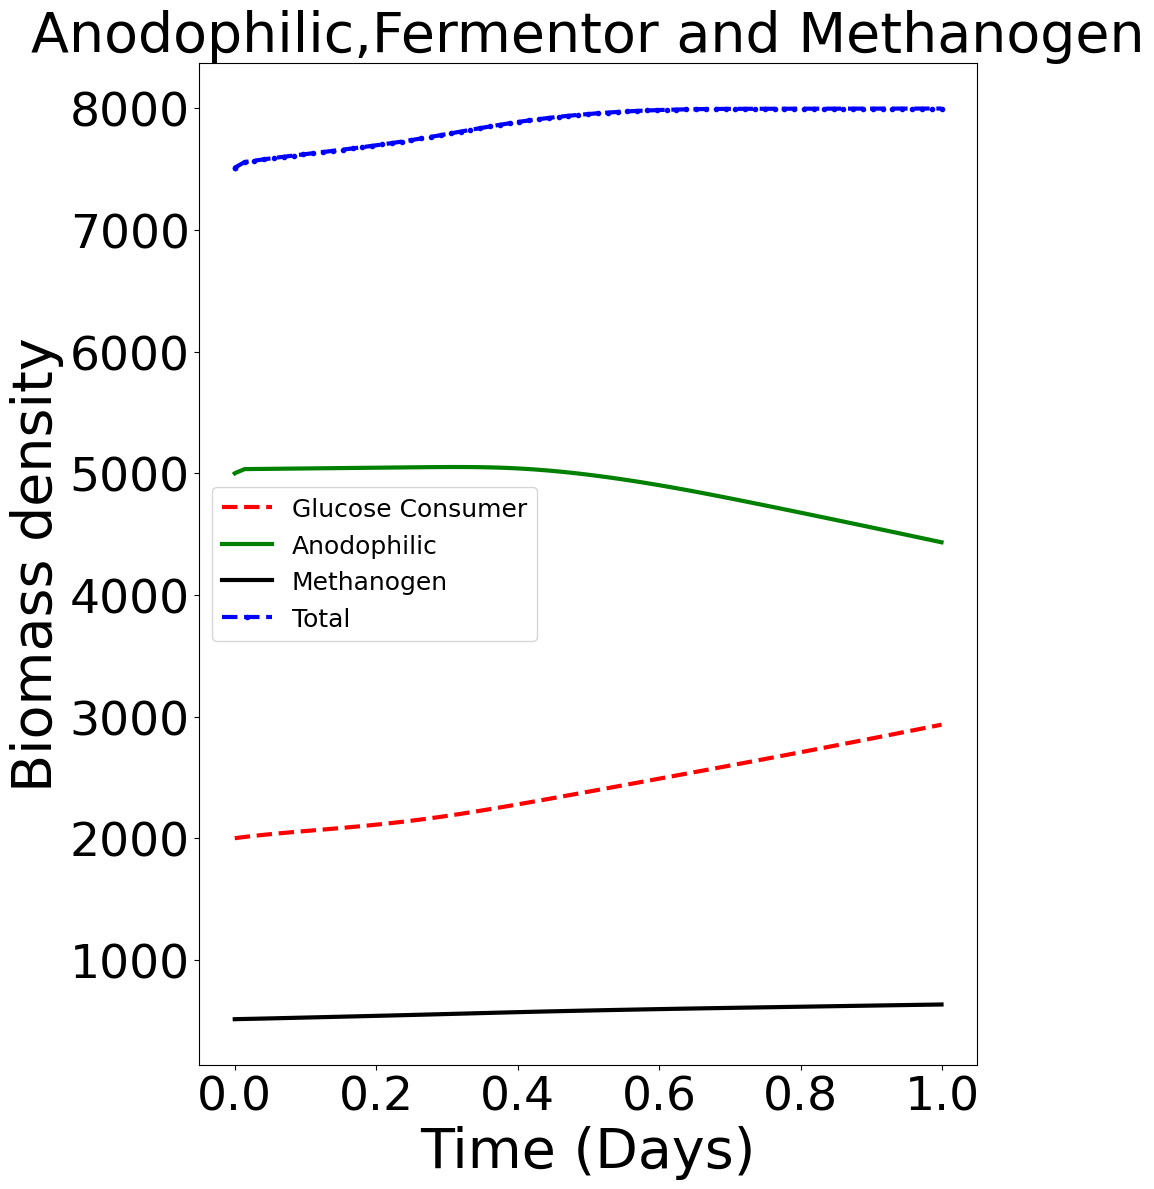

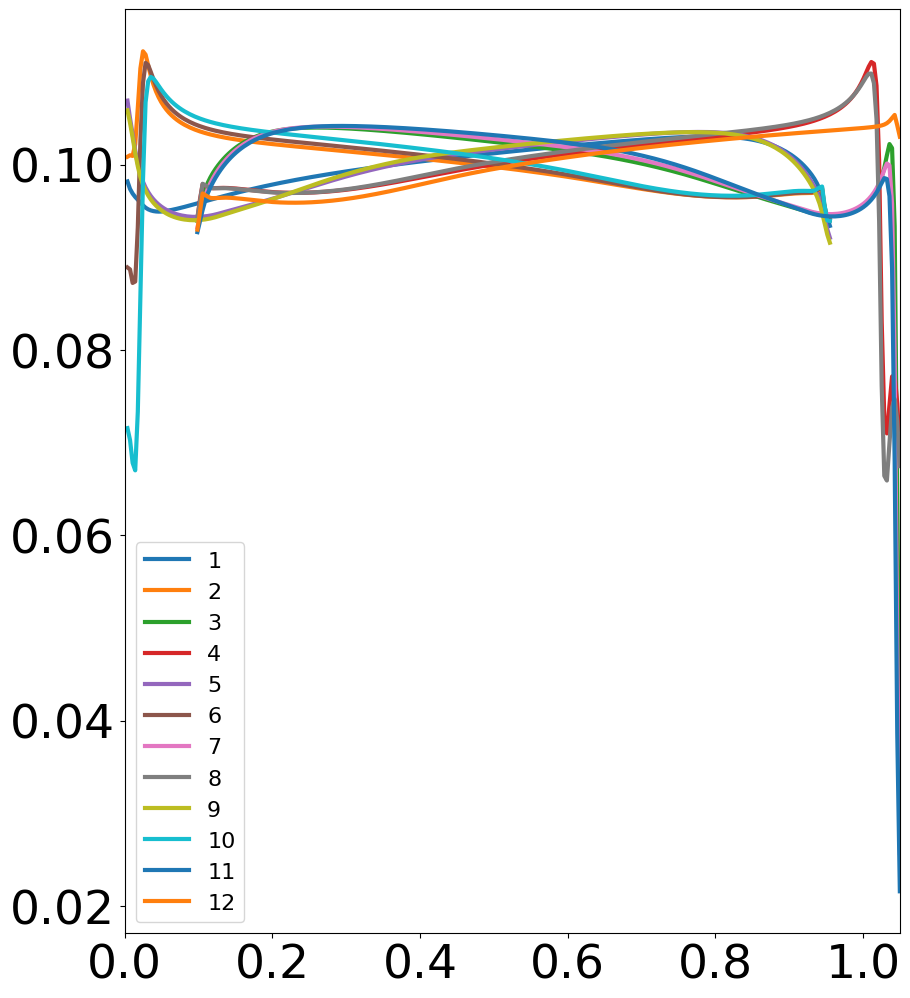

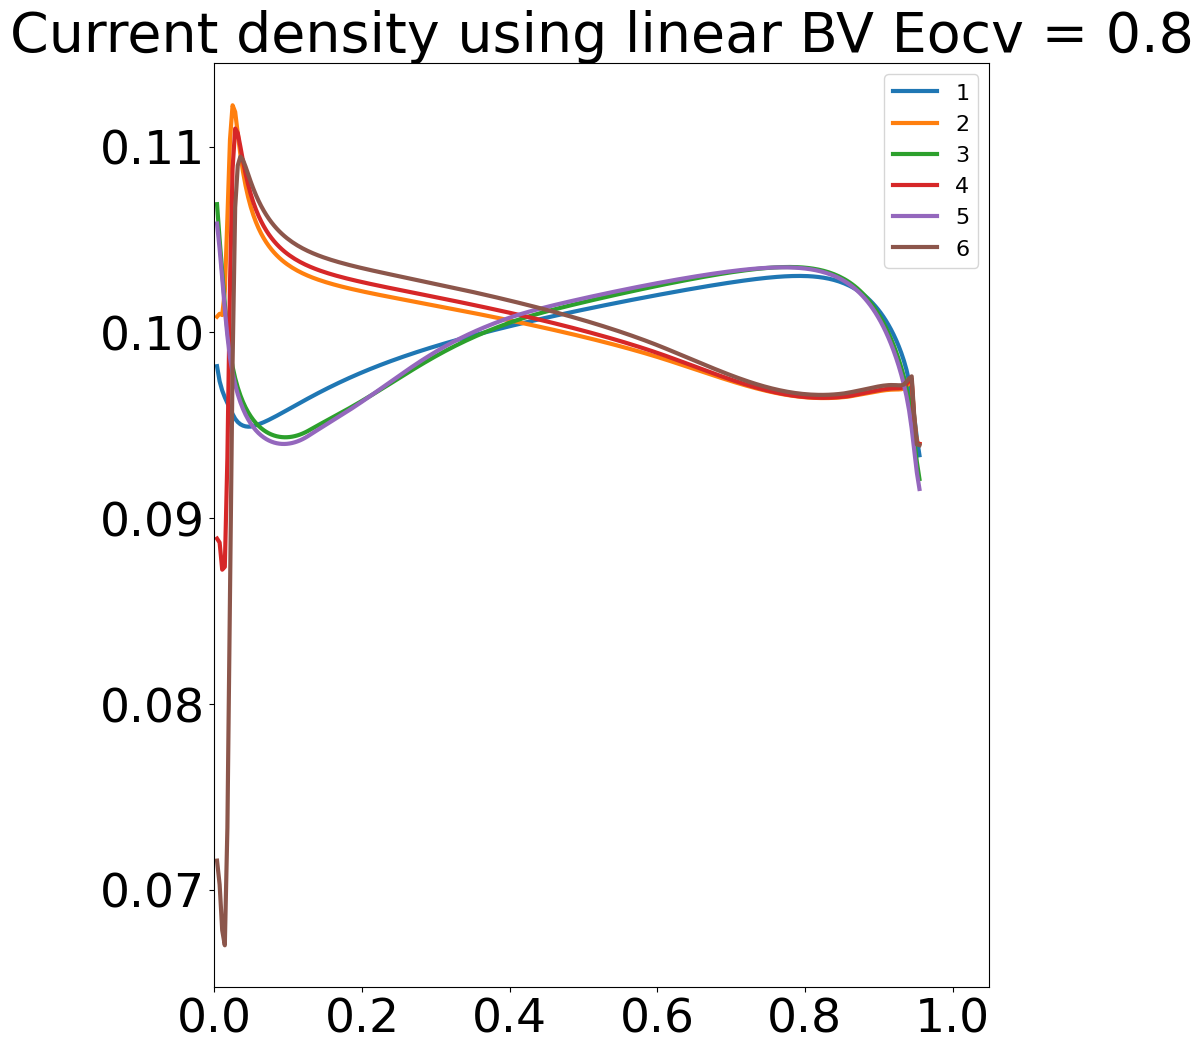

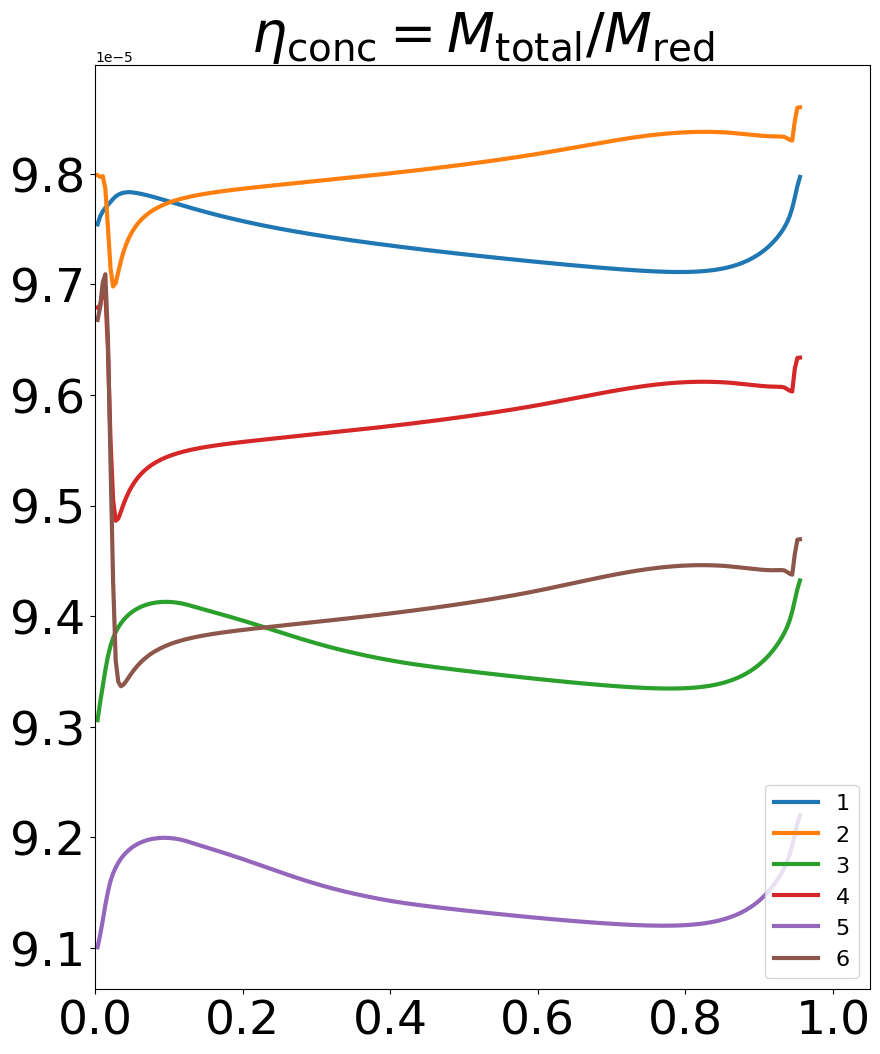

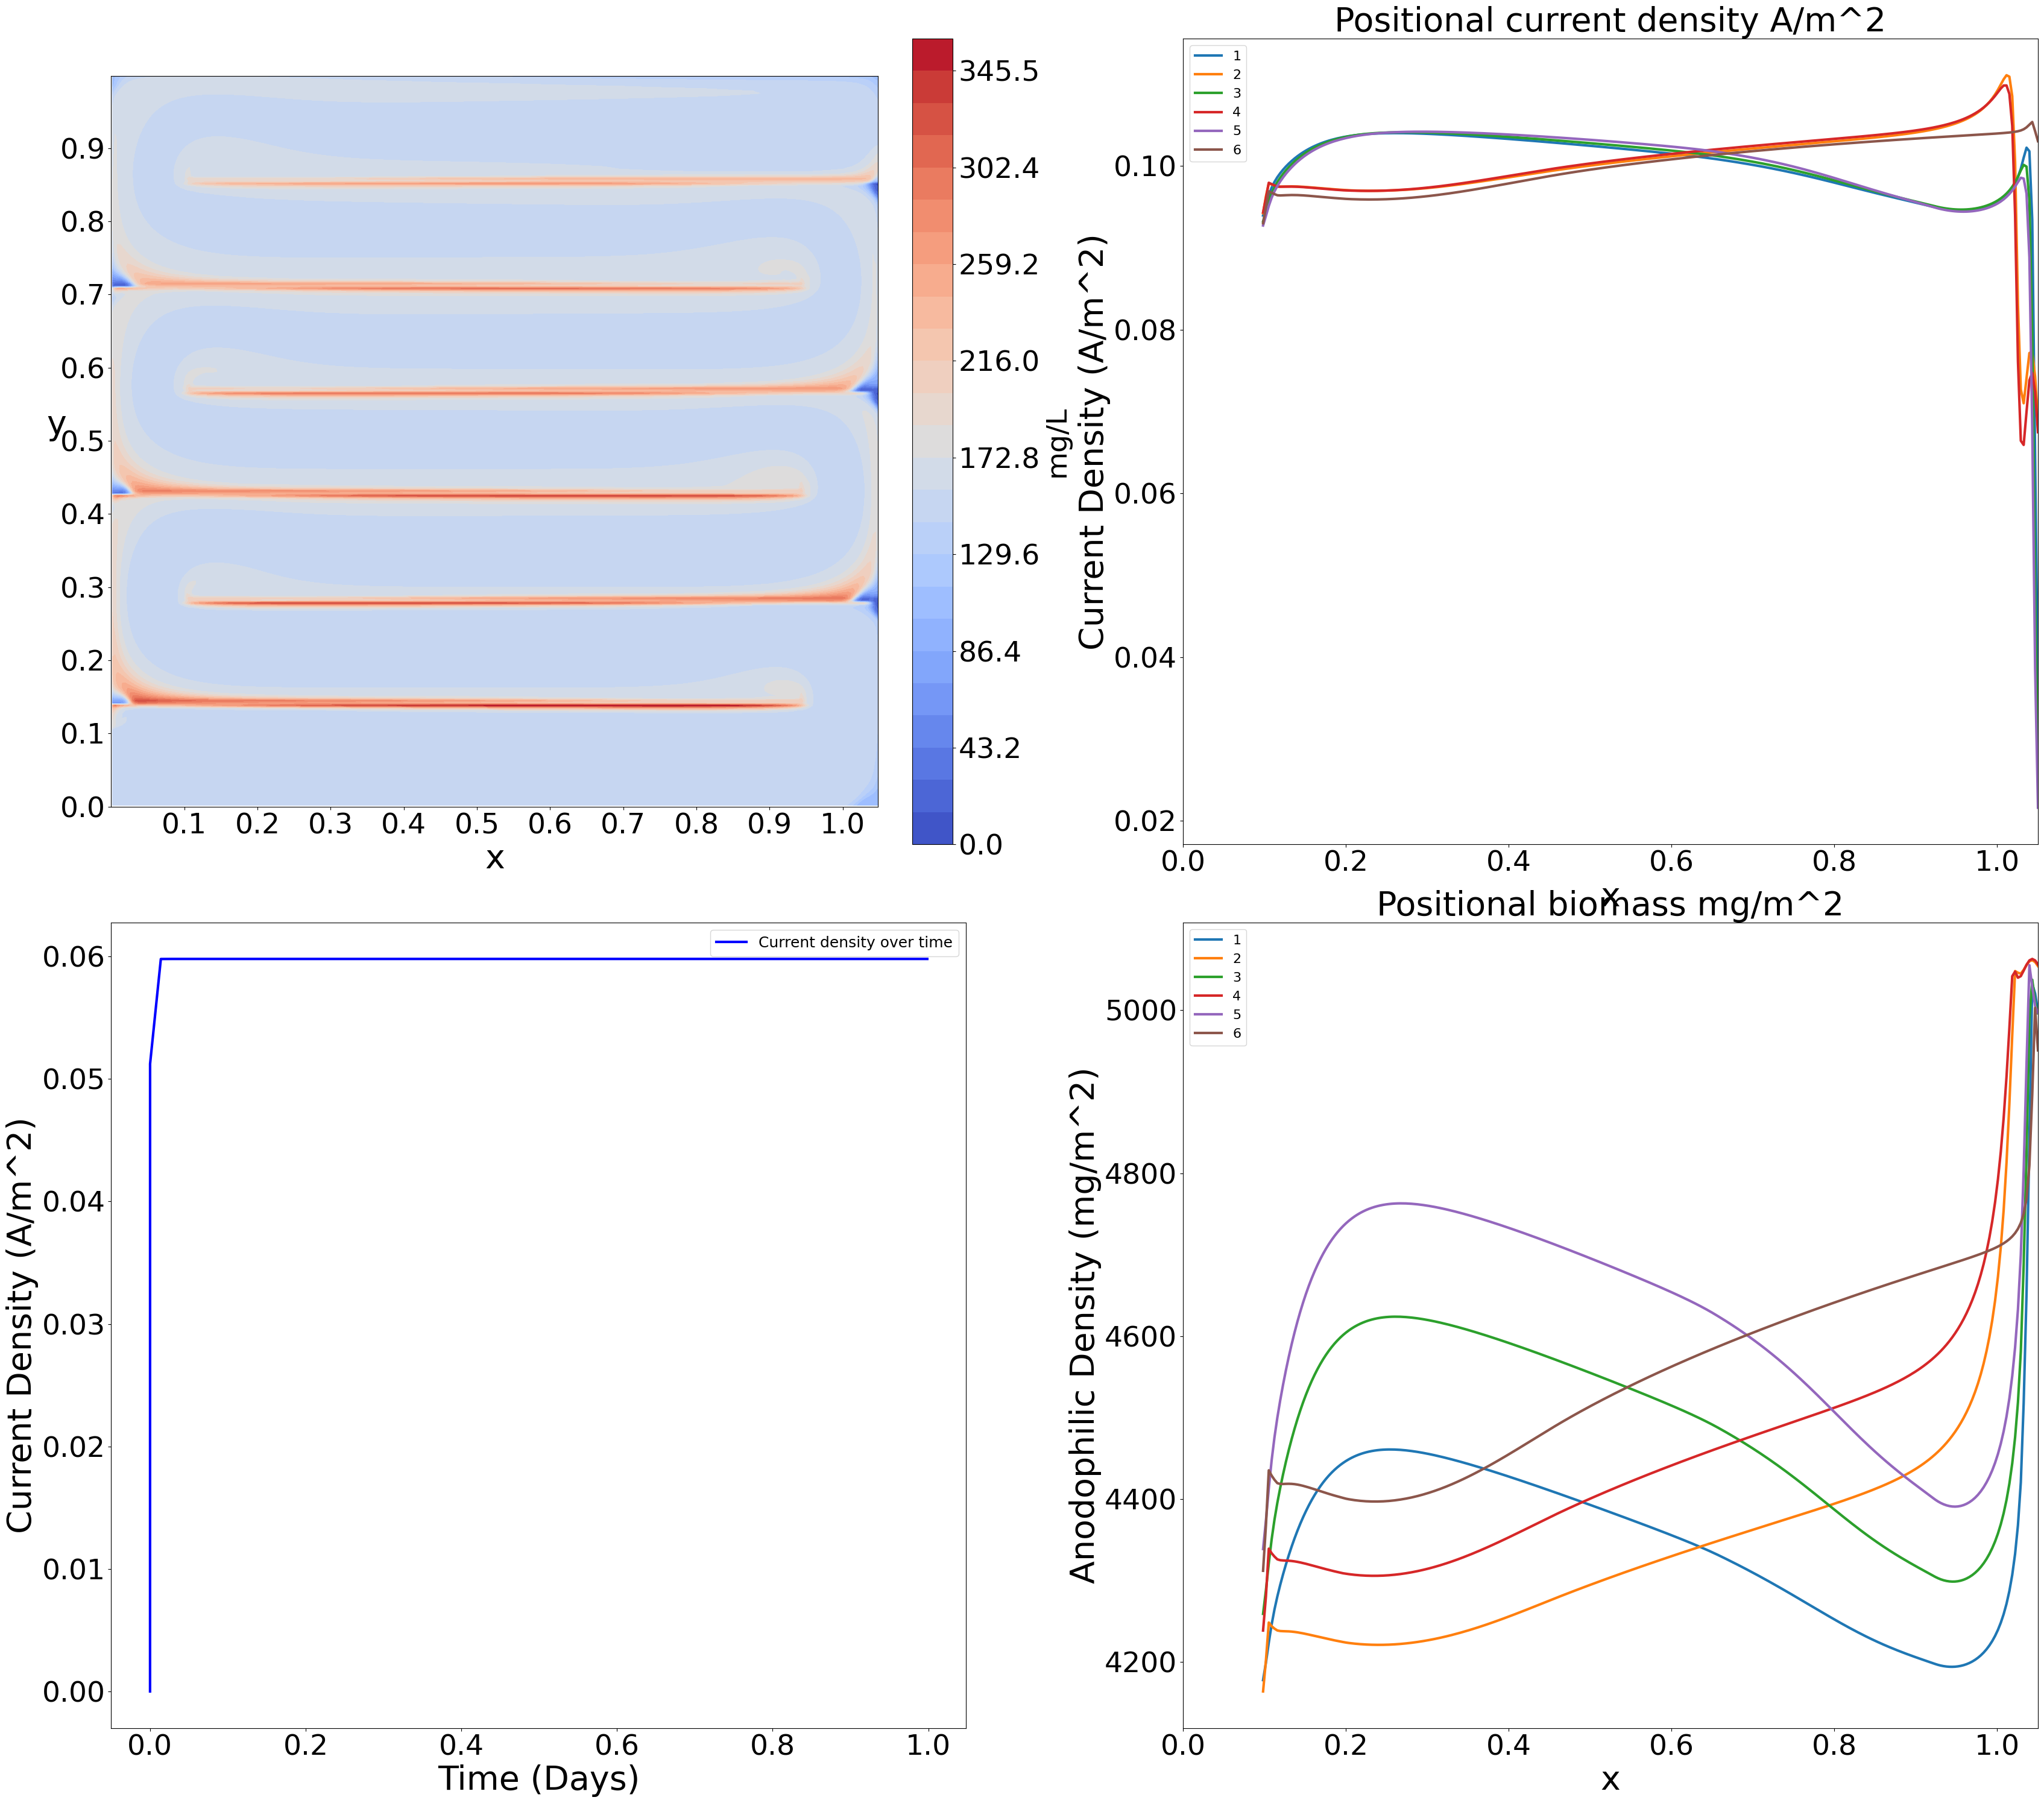

In [ ]:
# -*- coding: utf-8 -*-

# Copyright 2020 Jordan Day
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#


# import numpy as np
# import scipy as sp
from scipy import sparse
# from scipy.sparse import linalg
# import matplotlib.pyplot as plt
# import time
from tqdm import tqdm
from Fluid_classes import *
from Plotting_functions import *
import os
from pathlib import Path
import solver

np.random.seed(0)
nx = 300
ny = 300
nz = 1
Lx = 1.05  # length in m
Ly = 1  # length in m
Lz = 1.05  # length in m
hrt = 12  # hrt set in any given time units TC is the conversion to seconds
file_name = 'HRT_{}_ym_26_Three_Population_area_optimisation_side_'.format(int(hrt))  # File name to save output data

hrt *= TC_hour  # The hydraulic retention time converted into seconds
baffle_length = 91 / 100  # This is the fraction of the tank a baffle takes up in x
baffle_pairs = 3  # Number of baffle pairs (RHS+LHS) = 1 pair.

# Baffle param
rho = 8000
# Runtime for reactor system
RT = 1
RT *= TC_day
dt_max = 8
k = 20  # Store data every k min, 1 is every min, 2 every 2 min
D = 1 / hrt
anode_side = 'all'  # can either be 'all', 'influent', 'effluent' 'front_loaded' based on the layout you wish to test
file_name += anode_side
print(file_name)

dx = Lx / nx
dy = Ly / ny
x = np.linspace(0, Lx, nx).T
y = np.linspace(0, Ly, ny).T
[yy, xx] = np.meshgrid(np.linspace(dy / 2, Ly - dy / 2, ny), np.linspace(dx / 2, Lx - dx / 2, nx))

system = domain(Lx, Ly, Lz, nx=nx, ny=ny)

flux = (Lx * Ly) / hrt  # The "area flux" through the system
nxy = nx * ny
nxy_one = (nx + 1) * (ny + 1)
psi = np.zeros((nx + 1, ny + 1))  # This is the stream function
boundary = np.zeros((nx + 1, ny + 1))  # We set this to 1 on all boundary points
boundary[0, :] = 1
boundary[-1, :] = 1
boundary[:, 0] = 1
boundary[:, -1] = 1

edges = boundary
psi[0, 0:ny + 3] = flux
psi[:, -1] = flux
psi, boundary, in_out_points, in_start, out_start = system.influent_effluent_regions(baffle_pairs, baffle_length,
                                                                                     dy * 18, psi, boundary, flux)

bdata = psi[boundary == 1]

file_a = 'hrt' + str(hrt).replace('.', '_') + '_nx' + str(nx) + '_ny' + str(ny) + '_Lx' + str(Lx) + '_Ly' + str(
    Ly) + '_pairs' + str(baffle_pairs) + '_width' + str(np.round(baffle_length, decimals=1)).replace('.',
                                                                                                     '_') + '.csv'
file_x = 'Ux_' + file_a
file_y = 'Uy_' + file_a
data_folder = Path(os.getcwd(),'Velocity Fields')

try:
    ux = np.genfromtxt(data_folder / file_x, delimiter=',')
    uy = np.genfromtxt(data_folder / file_y, delimiter=',')
    print('Velocity Files loaded from text files')
except:
    psi, ux, uy, resid = solver.steady_state(boundary, psi, nx, ny, dx, dy,error=1e-6)  # Using function to determine steady state
    save_velocity_fields(file_a,['Velocity Fields'],ux,uy)
    print('Velocity fields have been determined and saved in text files \n')

# %%
external = np.zeros(boundary.shape)
external[0, :] = 1
external[-1, :] = 1
external[:, 0] = 1
external[:, -1] = 1
internal = boundary - external
bio_loc = np.zeros(boundary.shape)
bio_loc[:, 0:ny] += internal[:, 1:ny + 1]
bio_loc[:, 1:ny + 1] += internal[:, 0:ny]
bio_loc = bio_loc[0:nx, 0:ny]
if baffle_length == 0 and baffle_pairs == 0:
    bio_loc[1:-1, -2] = 1
    bio_loc[1:-1, 1] = 1

positional = np.nonzero(np.mean(bio_loc, 0))
switch = np.zeros(bio_loc.shape)
if anode_side == 'influent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][0:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('influent facing anodes are active')
elif anode_side == 'effluent':
    glucose_loc = 1*bio_loc
    switch[:, positional[0][1:20:2]] = 1  # :2 to alternate front and back on off 1:20:2 is back, 0:20:2 is front
    bio_loc *= switch
    print('effluent facing anodes are active')
elif anode_side == 'front_loaded':
    switch[:, positional[0][10:20:1]] = 1
    glucose_loc = 1 * bio_loc
    bio_loc *= switch
    #glucose_loc = glucose_loc - bio_loc
    print('First 5 carts are fermenting only')
else:
    anode_side = 'all'
    #switch[:, positional[0][11:20:1]] = 1
    #bio_loc *= switch
    glucose_loc = 1 * bio_loc
    print('All anodes are active')

bio_number = np.count_nonzero(bio_loc)
glucose_number = np.count_nonzero(glucose_loc)
# %%

anode_numbers = np.count_nonzero(np.mean(bio_loc, 0))

# Determine anode area based on biofilm and baffle length
Ai = dx * Lz
A = baffle_length * nx * Ai
# A = Lx * Lz #anode area
# Ai = A/nx # area per cell

Vol = Lx * Ly * Lz * 1e3  # Volume in
Voli = dx * dy * Lz * 1e3  # Local volume in L

convert_m2_l = Ai / Voli
convert_l_m2 = Voli / Ai

z1 = MicrobialPopulation(5000 * np.ones(bio_number)  # np.random.normal(loc = 1000,scale = 10,size = (nx,2)) #initial
                         , 7.9 / TC_day  #7.9 / TC_day  # consumption
                         , 2*0.7 / TC_day  # growth
                         , 0.02  # decay
                         , 20 # sub monod const
                         , 'Anodophilic'  # Defining anodophilic species as class
                         , 5000
                         , mediator_monod=0.2 * 1)

z3 = MicrobialPopulation(512 * np.ones(glucose_number)
                         , 8.3 / TC_day
                         , 2*0.3 / TC_day
                         , 0.02
                         , 80
                         , 'Methanogenic',
                         5000)

z2 = MicrobialPopulation( 2000 * np.ones(glucose_number)
                         , 4.8/ TC_day
                         , 2*0.4 / TC_day
                         , 0.02
                         , 100
                         , 'Glucose Consumer'
                         , 2000)

# Doubles initial bacteria conc on biofilms without electrogens
z2_space = 0*glucose_loc
z2_space[glucose_loc == 1] = z2.current
z2_space[glucose_loc - bio_loc == 1] = 4000
z2.current = z2_space[glucose_loc==1]

z3_space = 0*glucose_loc
z3_space[glucose_loc == 1] = z3.current
z3_space[glucose_loc - bio_loc == 1] = 2*z3.current.max()
z3.current = z3_space[glucose_loc==1]


s = Substrate(100 * np.ones((nx, ny)), influent=150, diffusion=1e-9, name='Acetate')
s.current = s.update_influent(baffle_pairs, in_out_points, ny)
s2 = Substrate(100* np.ones((nx, ny)),influent= 1500,diffusion= 1e-9,name = 'Glucose') # 300 or 1500
s2.current = s2.update_influent(baffle_pairs, in_out_points, ny)
s2.s_yield = 0.7 ################################################### Latest run using 0.8 as Ac yield

m_total = 1  # mg-M / mg-Z Initial mediator

mox = Parameters(0.99 * m_total * np.ones(bio_number), name='Oxidised Mediator')

mred = Parameters(m_total - mox.initial, name='Reduced Mediator')
Ym = 26#22.75  # mg-M /mg -s 36#32
m = 2  # mol-e / mol-M
gamma = 663400  # mg-M/mol-M
T = 298  # K
j0 = 1#e-2  # 1e-2-> almost identical to 1, but much faster run times
BV_full = False

j_min = 1.60
j_max = 1.60  # 1.34#0.64
##############################################
# changed here and j_0 ###
E_min_scaled = j_min * (A * 500)  # /(R*T/(m*F*j0))Anode area times sum of res
E_max_scaled = j_max * (A * 500)  # /(R*T/(m*F*j0)) Anode area times sum of res

#############################################
j_test = 1.5  # .4#2.4#1.6#2.4/10  # 40 j0 = 1e-4
# Full BV stable for hrt = 2, 6, j0 = 1e-4 , J_test = 1.4

Rin = Parameters(0, minimum=7, maximum=7, k=0.006 * A / Vol, name='Internal Resistance')
Rex = 1  # ohm
E_test = 0.8  # j_test * (A * (Rin.minimum+Rex)) # j_test*(R*T/(m*F*j0)+500*A*(0.92/0.08)/(0.92/0.08))

E = Parameters(0, minimum=E_test, maximum=E_test, k=0.0006, name='Voltage')
# E = Parameters(0, minimum=10, maximum=10, k=0.0006, name='Voltage')

# E_ocv = E_test * bio_loc
# E_ocv[:,270:273:2] = 0.9*(A * (Rin.minimum+Rex))
# E_ocv = E_ocv[bio_loc == 1]
# E.current = E_ocv


pref = gamma / (m * F)
I = Parameters(0, name='Current (Not to be confused with current value)')
s_blank = np.zeros((bio_number, 5000))
ij = 0
t = GeneralVariable(0, name='Time')
Rin.current = Rin.minimum  # +(Rin.maximum - Rin.minimum)*np.exp(-Rin.k*sum(z1.initial)/nx) + Rex
Rin.storage[0] = Rin.current

# setting up locations for biofilm
# bio_loc = np.zeros((nx,ny))
bio_upper = np.zeros((nx, ny))
bio_lower = np.zeros((nx, ny))
bio_lower[:, -2] = 1  # used for plotting
bio_upper[:, 1] = 1
consump = np.zeros((nx, ny))  # setting consumption array
med_dist = np.zeros(consump.shape)

ux_max = np.max(ux)  # max velocity based on steady state
uy_max = np.max(uy)  # max vel from steady state
# Creating sparse matrix for biofiolm diffusion]
positions = [-1, 0, 1]
diag_x = np.array([[1 / (dx ** 2)], [-2 / (dx ** 2)], [1 / (dx ** 2)]]).repeat(nx, axis=1)
diag_y = np.array([[1 / (dy ** 2)], [-2 / (dy ** 2)], [1 / (dy ** 2)]]).repeat(ny, axis=1)
Dx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # d/dx mat Alternate approach to using diffuse_S array
Dy = sp.sparse.spdiags(diag_y, positions, ny, ny)  # d/dy mat
kappa_bio = 1e-12  # diffusion rate for biofilm
Dx_bio = sp.sparse.spdiags(diag_x, positions, nx, nx).tolil()
Dx_bio[0, -1] += 1 / (dx ** 2)  # Periodic Boundary Conditions
Dx_bio[-1, 0] += 1 / (dx ** 2)  # Periodic BC

Dx_bio *= kappa_bio  # setting up diffusion array for biofilm
Dx_bio = Dx_bio.tocsr()

Bx = sp.sparse.spdiags(diag_x, positions, nx, nx)  # tolil()
By = sp.sparse.spdiags(diag_y, positions, ny, ny)
Iy = sp.sparse.eye(ny)
Ix = sp.sparse.eye(nx)
Diffuse_s = (sp.sparse.kron(Iy, Bx) + sp.sparse.kron(By, Ix)).tolil()

bio_diffusion_x = sp.sparse.kron(Iy, Bx).tolil()
temp_location = np.zeros((nx + 1, ny + 1))
temp_location[:-1, :-1] = bio_loc

for ii in np.arange(nxy):
    ix = int(ii % nx)
    iy = int(np.floor(ii / nx))
    jj = iy * (nx + 1) + ix

    # Fix: Retrieve current value, add scalar, and set back
    current_value = Diffuse_s[ii, ii]  # Get the current value
    Diffuse_s[ii, ii] = current_value + 1 / (dx ** 2)  # Modify and assign back

    if ix != 0:
        Diffuse_s[ii, ii - 1] = 0

    if boundary[ix + 1, iy] * boundary[ix + 1, iy + 1] == 1:  # Boundary on right
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dx ** 2)
        if ix != nx - 1:
            Diffuse_s[ii, ii + 1] = 0

    if boundary[ix, iy] * boundary[ix + 1, iy] == 1:  # Boundary below
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != 0:
            Diffuse_s[ii, ii - nx] = 0

    if boundary[ix, iy + 1] * boundary[ix + 1, iy + 1] == 1:  # Boundary above
        Diffuse_s[ii, ii] = Diffuse_s[ii, ii] + 1 / (dy ** 2)
        if iy != ny - 1:
            Diffuse_s[ii, ii + nx] = 0

    if temp_location[ix, iy] * temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix == 0:
        bio_diffusion_x[ii, ii] += 1 / (dx ** 2)
    if ix != 0:
        if temp_location[ix - 1, iy] * temp_location[ix, iy] == 0:
            bio_diffusion_x[ii, ii] += 1 / (dx ** 2)

    if temp_location[ix, iy] + temp_location[ix + 1, iy] == 0:
        bio_diffusion_x[ii, ii] -= 1 / (dx ** 2)

Diffuse_s = Diffuse_s.tocsr()
LU = sp.sparse.linalg

bio_diffusion_x = 0*1e-9 * bio_diffusion_x.tocsr()
z1.biomass_diffusion(bio_loc,bio_diffusion_x)
z2.biomass_diffusion(glucose_loc,bio_diffusion_x)
z3.biomass_diffusion(glucose_loc,bio_diffusion_x)

# (Rest of the code remains unchanged and continues here...)


z1.calculate_positional_distribution(bio_loc)
temp = bio_diffusion_x.dot(np.reshape(z1.positional_distribution.T, nxy))
temp = np.reshape(temp.T, (ny, nx)).T
temp[bio_loc != 1] = 0  # Deals with mass produced outside of biofilm! (temp fix)

del temp_location

s.storage[:, :, 0] = s.initial
s.current[:, :] = s.initial  # This line causes s.initial to be linked to s.now

dt = min(dt_max, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
        2 * s.diffusion * (dx ** 2 + dy ** 2)))
# dt = np.floor(dt*100)/100

ii = 0
rk = np.array([[0, 1 / 2, 1 / 2, 1], [0, 1, 1, 1], [1, 2, 2, 1]]).T
bound_out = np.zeros(s.current.shape)
bound_in = np.zeros(s.current.shape)
bound_out[-1, :] = 1
bound_out[:, -1] = 1
bound_out[:, 0] = 1
bound_in[-2, :] = 1
bound_in[:, -2] = 1
bound_in[:, 1] = 1

E.current = E.minimum
Rin.current = Rin.minimum
Rsig = Rin.current + Rex

mred.current = m_total - mox.current
eta_conc = R * T / (m * F) * np.log(m_total / mred.current)

med_dist[bio_loc == 1] = Ai * mred.current / mox.current
summation = np.array([Rsig * np.sum(med_dist, 0), ] * nx)
summation_shaped = summation[bio_loc == 1]
j = (mred.current / mox.current * (E.current - eta_conc)) / (
        R * T / (m * F * j0) + summation_shaped)
del eta_conc

print("System will simulate a {} baffle system with a fluid HRT of {} hours and bio runtime of {} days".format(
    2 * baffle_pairs, hrt / TC_hour, RT / TC_day))

start_time_bio = time.time()
storage_steps = int(k * 60 / dt)
z1.diffused *= 0
z2.diffused *= 0
z2.diffused *= 0
combined_max = 8000
total_time = time.time()
pbar = tqdm(total=101, desc="Progress of simulation", ncols=100, )

fermenting_bio_loc = glucose_loc - bio_loc

while t.current < RT + 10:
    ii += 1
    lt = time.time()
    irk = 0
    consump *= 0  # Reset consumption

    # Switch flow on/off based on the cycle duration
    current_cycle_time = t.current % cycle_duration
    if current_cycle_time < flow_on_duration:
        flow_switch = True  # Flow is ON
    else:
        flow_switch = False  # Flow is OFF

    while irk < 4:  # replaced with while loop to allow for adaptive timesteps
        if irk == 0:
            z1.intermediate = z1.current
            z3.intermediate = z3.current
            s.intermediate = s.current
            mox.intermediate = mox.current
            mred.intermediate = m_total - mox.intermediate

            z2.intermediate = z2.current
            s2.intermediate = s2.current
        else:
            z1.update_intermediate(rk, irk, dt)
            z3.update_intermediate(rk, irk, dt)
            s.update_intermediate(rk, irk, dt)
            mox.update_intermediate(rk, irk, dt)
            mred.intermediate = m_total - mox.intermediate

            # Update influent only when the flow is ON
            if flow_switch:
                s.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                    int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s.influent

            z2.update_intermediate(rk, irk, dt)
            s2.update_intermediate(rk, irk, dt)
            if flow_switch:
                s2.intermediate[0, round(int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2)):round(
                    int(1 / 2 * ny * 1 / (2 * baffle_pairs + 1) - in_out_points / 2 + 1 + in_out_points))] = s2.influent

        if (mox.current + (dt / 6) * mox.ddt2 > m_total).any() or (
                mox.current + rk[irk, 0] * dt * mox.ddt1 > m_total).any():
            # If over estimating rk4 loop is reset with smaller timestep
            irk = 0
            dt *= 0.5
            continue


        local_g = np.reshape(s2.intermediate[glucose_loc == 1], (glucose_number))
        z2.update_growth_and_consumption(local_g)
        z2.first_timestep()
        z2.second_timestep(rk, irk)

        local_s = np.reshape(s.intermediate[bio_loc == 1], bio_number)
        local_s_meth = np.reshape(s.intermediate[glucose_loc == 1], (glucose_number))

        substrate_mean_surface = anode_surface_sum(Ai * local_s, bio_loc) / A

        j, eta_act = current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
        I_anode = anode_surface_sum_repeated(j * Ai, bio_loc)
        mediator_current_density_term = I_anode / A

        # local_s = np.reshape(s.intermediate[bio_loc == 1], (bio_number))
        z1.update_growth_and_consumption(local_s, mox.intermediate)
        z3.update_growth_and_consumption(local_s_meth)
        # diff_z1 = 0  # *Dx_bio.dot(vdata1[0,])
        # diff_z3 = 0  # *Dx_bio.dot(vdata1[1,]) # diffusion of X and Z
        z1.biomass_diffusion(bio_loc, bio_diffusion_x)
        z3.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z2.biomass_diffusion(glucose_loc, bio_diffusion_x)
        z1.first_timestep()
        z1.second_timestep(rk, irk)
        z3.first_timestep()
        z3.second_timestep(rk, irk)
        mox.ddt1 = -Ym * z1.consumption + pref * j / z1.intermediate
        mox.second_timestep(rk, irk)
        s.calculate_advection(ux, uy, dx, dy)  # Advection is slowest process
        s.calculate_diffusion(Diffuse_s)  # diff is second slowest
        s.calculate_consumption(z1, z3, biofilm_location=bio_loc, convert_m2_l=convert_m2_l,biofilm_location2=glucose_loc)  # rapid
        fluid_time = time.time()
        s.first_timestep()  # Timestepping is almost as slow as diff
        s.created = -s2.s_yield * s2.consumption
        s.ddt1 += s.created
        s.second_timestep(rk, irk)
        s2.calculate_advection(ux, uy, dx, dy)
        s2.calculate_diffusion(Diffuse_s)
        s2.calculate_consumption(z2, biofilm_location=glucose_loc, convert_m2_l=convert_m2_l)
        s2.first_timestep()
        s2.second_timestep(rk, irk)
        irk += 1  # move forward in rk4 loop
        if irk == 4 and (mox.current + (dt / 6) * mox.ddt2 > m_total).any():
            irk = 0
            dt *= 0.5
            # print('Loop restart')
            continue

    z2.update_current(dt)
    s2.update_current(dt)

    z1.update_current(dt)
    z3.update_current(dt)
    s.update_current(dt)
    mox.update_current(dt)
    mred.current = m_total - mox.current

    j, eta_act, eta_conc = current_density(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=BV_full)
    I.current = np.sum(Ai * j)
    t.current += dt
    dt = min(dt_max, dt * 2, 1 / (ux_max / dx + uy_max / dy), (dx ** 2 * dy ** 2) / (
            2 * s.diffusion * (dx ** 2 + dy ** 2)))  # increase timestep up to 2 or double previous timestep
    s.current = s.update_influent(baffle_pairs, in_out_points, ny)
    z2.calculate_positional_distribution(glucose_loc)
    z3.calculate_positional_distribution(glucose_loc)
    temp_shared1 = z2.positional_distribution[bio_loc == 1]
    temp_shared2 = z3.positional_distribution[bio_loc == 1]
    total_biomass = z1.current + temp_shared1 + temp_shared2#+ z2.current
    if (total_biomass > rho).any():
        z1.current[total_biomass > rho] *= rho/total_biomass[total_biomass > rho]
        temp_shared1[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        temp_shared2[total_biomass > rho] *= rho / total_biomass[total_biomass > rho]
        z2.positional_distribution[bio_loc == 1] = temp_shared1
        z3.positional_distribution[bio_loc == 1] = temp_shared2


    temp_mass1 = z2.positional_distribution[fermenting_bio_loc == 1]
    temp_mass2 = z3.positional_distribution[fermenting_bio_loc == 1]
    total_biomass2 = temp_mass1 + temp_mass2
    if (total_biomass2 > rho).any():
        temp_mass1[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        temp_mass2[total_biomass2 > rho] *= rho / total_biomass2[total_biomass2 > rho]
        z2.positional_distribution[fermenting_bio_loc == 1] = temp_mass1
        z3.positional_distribution[fermenting_bio_loc == 1] = temp_mass2

    z2.current = z2.positional_distribution[glucose_loc == 1]
    z3.current = z3.positional_distribution[glucose_loc == 1]

    if ii % storage_steps == 0 or ii == 1:  # round(t.now,2)%(k*60) == 0 : #Storage of data
        ij += 1
        z1.storage[:, ij] = z1.current
        z3.storage[:, ij] = z3.current
        mox.storage[:, ij] = mox.current
        mred.storage[:, ij] = mred.current
        I.storage[ij] = I.current
        t.storage[ij] = t.current
        s.storage[:, :, ij] = s.current
        s_blank[:, ij] = z1.storage[:,ij-1] - z1.storage[:,ij]  # (muz-Kda)*vdata[0,]
        z2.storage[:,ij] = z2.current
        s2.storage[:,:,ij] = s2.current

        increase = round((t.current - t.storage[ij - 1]) / (RT + 20) * 100, 1)
        pbar.update(round(increase, 1))

#

gl_removal_percent = (s2.influent - mean_effluent(s2,in_out_points,out_start))/s2.influent*100
s_removal_percent = (s.influent - mean_effluent(s,in_out_points,out_start))/s.influent*100
influent_cod = s2.influent*1.07+s.influent*1.06
effluent_cod = mean_effluent(s2,in_out_points,out_start)*1.07 + mean_effluent(s,in_out_points,out_start)*1.06
cod_removal_percent = (influent_cod - effluent_cod)/influent_cod*100
print('\n HRT: {} hours\n Glucose removal percent: {} \n Acetate removal percent: {} \n COD removal percent: {} \n Current Density: {} \n'.format(hrt/TC_hour,
    gl_removal_percent,s_removal_percent,cod_removal_percent,j.mean()))

#save_data_classes_two_substrates(file_name,['Output','temp'],s,z1,mox,mred,j,t,s2,z2)
save_data_classes_two_substrates(file_name,['Output','Three_Population_Files'],s,z1,mox,mred,j,t,s2,z2,z3)

z1.update_mean(0)
z2.update_mean(0)
z3.update_mean(0)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average),sty = 'r--',linelabel = 'Glucose Consumer',new_fig=True)
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z1.average),sty = 'g-',linelabel = 'Anodophilic',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z3.average),sty = 'k-',linelabel = 'Methanogen',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )
plot_time_series(t.storage[0:ij+1]/TC_day,np.trim_zeros(z2.average+z1.average+z3.average),sty = 'b.--',linelabel = 'Total',xlab='Time (Days)', ylab= 'Biomass density',title= 'Anodophilic,Fermentor and Methanogen' )

print(t.current)
plot_positional_data(x, j, bio_loc, new_fig=True)

print(current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=False))
current_density_inter(E, Rin, Rex, m_total, mred, mox, bio_loc, Ai, R, T, m, F, j0, full=True)

print(dt, t.current)
plot_positional_data(x, j, bio_loc, new_fig=True, side='Left',
                     title='Current density using linear BV Eocv = {}'.format(E.current))

plot_positional_data(x, eta_conc, bio_loc, side='left', new_fig=True,
                     title='$\eta_\mathrm{conc} = M_\mathrm{total}/M_\mathrm{red}$')

plt.figure(figsize=(34, 30))
plt.subplot(221)
plot_contour(xx, yy, s.current)
plt.subplot(222)
plot_positional_data(x, j, bio_loc, side='right', title='Positional current density A/m^2',ylab = 'Current Density (A/m^2)',xlab = 'x')
plt.subplot(223)
plot_time_series(t.storage[0:ij + 1] / TC_day, I.storage[0:ij + 1] / (20 * A), linelabel='Current density over time',ylab = 'Current Density (A/m^2)',xlab = 'Time (Days)')
plt.subplot(224)
plot_positional_data(x, z1.current, bio_loc, side='right', title='Positional biomass mg/m^2',ylab = 'Anodophilic Density (mg/m^2)',xlab = 'x')

